In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1233)
tf.random.set_seed(1233)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

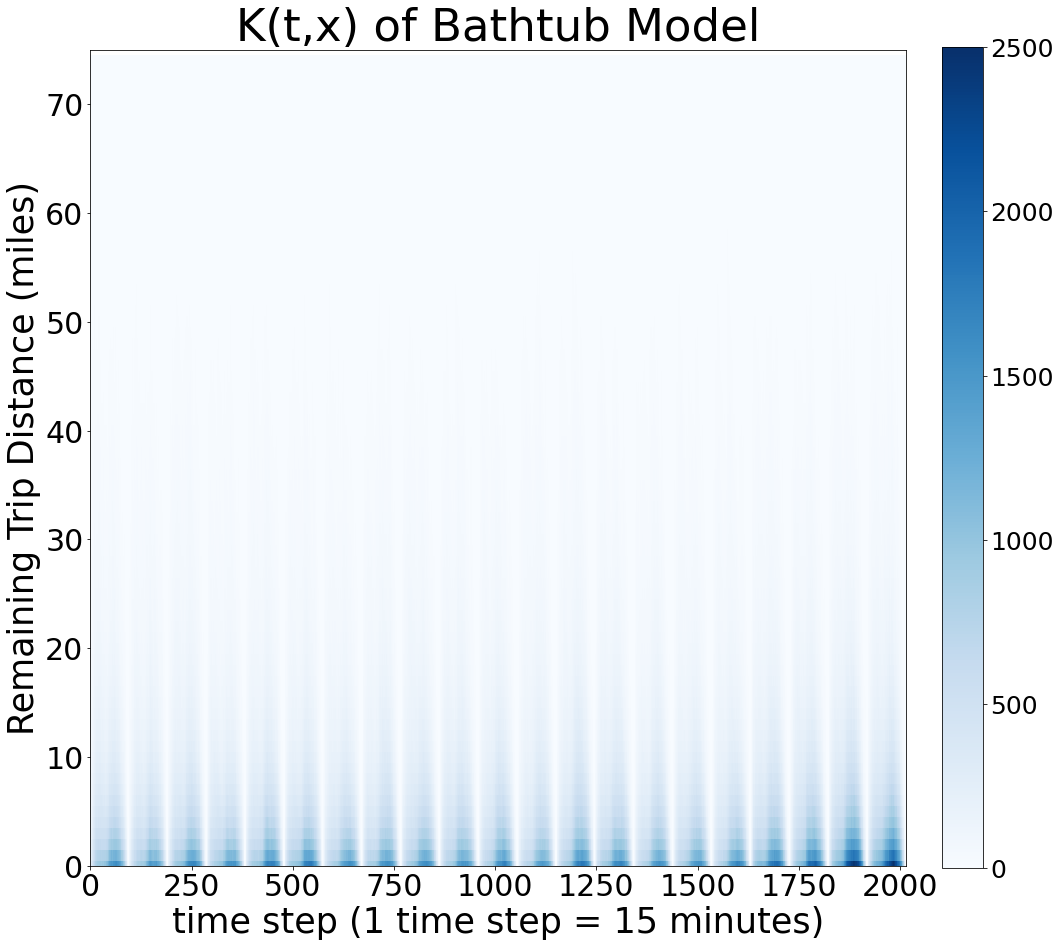

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  30240
N_u =  6048
N_f =  12096


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1233)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(6048, 2)

In [12]:
X_u_test.shape

(24192, 2)

In [13]:
X_u_train

array([[0.94594595, 0.37121588],
       [0.54054054, 0.4133995 ],
       [0.        , 0.27940447],
       ...,
       [0.33783784, 0.43920596],
       [0.94594595, 0.47096774],
       [0.40540541, 0.91414392]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.0067731540234750405 0.011718758256775787 0.0018275497901742938 0.8363098842090768
0.0061769515993358474 0.011424529508839154 0.00092937368983254107 0.8263056782105289
0.0054671289621487243 0.010613508657631407 0.00032074926666604173 0.7978539062300094
0.0053520414089751082 0.010324955853070767 0.00037912696487944921 0.7869910112032609
0.0050126884512573548 0.0095019917888912626 0.00052338511362344617 0.753285553706338
0.0049714743352766259 0.0094880900807373936 0.00045485858981585868 0.7521831474564193
0.0049653513029184644 0.0094860767664559156 0.000444625839381014 0.7519377697376254
0.0049532352059998971 0.009478510035014447 0.00042796037698534649 0.751427626431279
0.0049244092079827823 0.0094519608784800445 0.00039685753748552015 0.750048890931419
0.0048691186163997433 0.0093840861229818311 0.00035415110981765478 0.7469825866496178
0.0047824625365152449 0.0092470246561483678 0.00031790041688212179 0.7413434944487083
0.0046224680029629574 0.0089369475150580073 0.0003079884908679074

0.0030958052733407165 0.0053680127991104906 0.00082359774757094213 0.5712806845771559
0.0030949343107004013 0.0053576385132096619 0.000832230108191141 0.57078021575761
0.0030943292439102031 0.0053513355035379254 0.00083732298428248044 0.5704507625447979
0.0030938585717949986 0.005351642236963881 0.00083607490662611621 0.570454870261309
0.0030930756981661684 0.0053344367571691925 0.00085171463916314412 0.5694707670253181
0.0030921920454176546 0.0053213651644226775 0.00086301892641263151 0.5687504491379316
0.0030912746304954351 0.0053184657665327414 0.00086408349445812882 0.5685486084917168
0.003090182458902916 0.0053197958266731 0.000860569091132732 0.56870913166864
0.0030896349287267266 0.0053214653334986281 0.00085780452395482515 0.5687720961608665
0.0030888085288042597 0.0053359368090584976 0.00084168024855002174 0.5695049963662013
0.0030880625632976871 0.0053486774165334618 0.00082744771006191219 0.5703198021824635
0.0030871787231028444 0.0053272659061547687 0.00084709154005092044 0

0.0030710677136382906 0.005304497956663593 0.00083763747061298827 0.5675587770213493
0.0030708079667119892 0.0053118237543817257 0.00082979217904225215 0.5679596052681256
0.0030706035266686717 0.0053016146826750125 0.00083959237066233091 0.5674346842951402
0.0030704719723432077 0.0053061584581921882 0.00083478548649422739 0.567676654742901
0.0030704253137789949 0.0053087522920096664 0.00083209833554832293 0.5677994637311656
0.0030688233114233442 0.0052958095025222775 0.0008418371203244106 0.566910961706133
0.0030678099784218291 0.0052854443810154712 0.00085017557582818743 0.5661971923859915
0.0030647670160199067 0.0052471538673150263 0.00088238016472478675 0.5639981351309026
0.0030612615366677524 0.0052367592715752186 0.00088576380176028633 0.5633842359486463
0.003059881106981909 0.005237470987923043 0.00088229122604077529 0.5635162123696571
0.0030572713796022449 0.0052939226949524484 0.000820620064252041 0.5665227395668649
0.0030562791383186307 0.0052840643580419613 0.0008284939185953

0.0030028638057973639 0.0051727073135071893 0.00083302029808753856 0.5589904742552668
0.0030022303805088872 0.0051688358403763086 0.00083562492064146582 0.5588191204410144
0.0030018248530557044 0.0051579507676967331 0.00084569893841467548 0.5582532291309956
0.0030008300316693064 0.0051663599094299035 0.000835300153908709 0.5586125465615808
0.0029991810580653135 0.0051572771557990369 0.00084108496033158994 0.5580426416478046
0.0029981365718869625 0.005157161044074667 0.00083911209969925779 0.5580344690058952
0.0029980705748569388 0.0051721577606706906 0.00082398338904318691 0.5587756757449136
0.0029977447716400844 0.0051733990510349631 0.00082209049224520568 0.5589342847389182
0.002997493313542837 0.00515900155406306 0.0008359850730226137 0.558105441315268
0.00299717545741342 0.0051573727991390773 0.0008369781156877627 0.5579905599326099
0.0029965338286823493 0.0051551390945028825 0.00083792856286181569 0.5577821652432708
0.0029956526699130483 0.005150233858306495 0.00084107148151960119

0.00296010161726949 0.0050608291697862564 0.00085937406475272346 0.552390636367026
0.0029599759426168675 0.0050504750069158494 0.000869476878317886 0.5519145038966887
0.0029596091354259428 0.0050534806589456818 0.00086573761190620355 0.5519949328532151
0.0029591967191867396 0.0050633655117108389 0.00085502792666264013 0.5524998912849753
0.00295881412204862 0.0050579108415558793 0.00085971740254136046 0.5522175058225445
0.0029584993969985927 0.0050613473781649272 0.000855651415832258 0.5524297290263205
0.0029582596672914404 0.00505842822750765 0.00085809110707523091 0.5522667758450476
0.0029580282612139078 0.00506185646192783 0.00085420006049998528 0.5525445269710383
0.0029579025883301291 0.0050601809511846285 0.0008556242254756293 0.5524153301708342
0.0029576245109556726 0.0050607257907713922 0.000854523231139953 0.5524350539145886
0.0029573813668164559 0.0050505756651979686 0.00086418706843494281 0.5518728014941173
0.0029571477989522388 0.0050606569924028285 0.00085363860550164913 0.5

0.0029403711960272628 0.004997649256516367 0.00088309313553815844 0.5489026208894116
0.0029402395777398307 0.0049974638016030736 0.00088301535387658734 0.5488790679567902
0.002939995202737009 0.0050018719221193225 0.00087811848335469557 0.549088272662341
0.0029398424578956192 0.0050012742307281033 0.00087841068506313517 0.5490942638191713
0.0029396491133756738 0.00500639864090023 0.0008728995858511173 0.5493565195936583
0.0029395140832955483 0.0050055108505297572 0.000873517316061339 0.5493371304589091
0.0029394282348617039 0.0049948925133525227 0.00088396395637088535 0.5486830707124741
0.0029392412995508858 0.00500092039832762 0.00087756220077415167 0.5490638791683111
0.0029391902201248029 0.0050013412256673679 0.000877039214582238 0.5491002256402981
0.0029391605573157969 0.0050009500833846556 0.00087737103124693825 0.5490438533813583
0.0029391349082445533 0.0049996517214181985 0.00087861809507090781 0.5489890408008865
0.0029391191629632566 0.0050002820382771271 0.00087795628764938646

0.0029326284851901277 0.0049911115246172475 0.000874145445763008 0.5483063823669287
0.0029324944787295654 0.0049932384916263244 0.00087175046583280638 0.5484272761697377
0.0029323833328587356 0.0049892177108752274 0.00087554895484224377 0.5482297784092681
0.0029322978339539831 0.0049870886774261835 0.00087750699048178232 0.5481106477354376
0.0029321822935401316 0.0049877823934174987 0.000876582193662765 0.5481615247262986
0.0029320697169611704 0.0049866972193028615 0.00087744221461947907 0.5481100381355208
0.0029320158244296127 0.0049892201528811192 0.00087481149597810664 0.5482665922182719
0.0029319571711339787 0.0049877948500683077 0.00087611949219965 0.5481868081015071
0.0029319072320610189 0.0049884657446936905 0.00087534871942834748 0.5482251994443468
0.0029318761530693015 0.004987983767763395 0.00087576853837520777 0.5481936112279849
0.0029318502132317675 0.00498636957146375 0.00087733085499978555 0.5480959990234121
0.0029318169181225865 0.0049857196387568569 0.000877914197488316

0.0029215229790565409 0.0049702604561051109 0.00087278550200797073 0.5480906251131208
0.002921349845237732 0.0049662311647386288 0.0008764685257368354 0.5478424832949395
0.0029212202329849031 0.004964824313228167 0.000877616152741639 0.5477839484116473
0.0029211300653160127 0.0049698596820836084 0.00087240044854841679 0.5480049186329229
0.00292091812661281 0.0049647294745068645 0.00087710677871875528 0.5478243137810347
0.0029206536979720487 0.0049595180414684281 0.0008817893544756691 0.5475810011265202
0.0029203506558130275 0.0049594030708705519 0.00088129824075550286 0.5475614572090775
0.0029200403077945226 0.004956733206074552 0.00088334740951449288 0.5474669293596879
0.0029197814099809318 0.00495937367922638 0.00088018914073548357 0.5475672468120417
0.0029195857590372434 0.0049548522240851689 0.00088431929398931775 0.547355970478555
0.0029195051193222398 0.0049572041241232358 0.00088180611452124411 0.5474928608966865
0.0029194606017826251 0.0049592377306521074 0.00087968347291314248

0.0029026454650372866 0.0049323221534422028 0.00087296877663237008 0.5461745017698929
0.0029026155270035687 0.0049328623003831416 0.000872368753623996 0.5461992862409557
0.0029025714732847704 0.0049323183934522185 0.00087282455311732258 0.5461840585554452
0.0029025316007780634 0.0049324114736848763 0.0008726517278712508 0.5461993032788998
0.0029024867217183354 0.0049324376271048269 0.00087253581633184361 0.5462172987955167
0.0029024215307696779 0.0049317897782616216 0.00087305328327773367 0.5461928095146302
0.0029023686472115697 0.0049315995600503247 0.00087313773437281447 0.5461945847244076
0.0029023172311061943 0.00493092377285477 0.00087371068935761817 0.5461518921519913
0.00290225947032507 0.0049293973282696912 0.000875121612380449 0.5460442660762325
0.0029021881695388829 0.0049300230487838211 0.00087435329029394483 0.5460551268109796
0.0029021167777049874 0.0049270093085876107 0.00087722424682236367 0.5458637542598807
0.0029020113759348227 0.0049263313480316642 0.00087769140383798

0.0028911389588096078 0.00492846696818498 0.00085381094943423543 0.545679332626697
0.0028910098819014312 0.0049268222059219626 0.0008551975578809 0.5456138370751211
0.00289083740071121 0.0049245516629779487 0.0008571231384444716 0.5455156739161062
0.0028905622848147392 0.0049291467750731573 0.00085197779455632131 0.5457864823939861
0.0028903489320965207 0.0049299475462510093 0.000850750317942032 0.5458558046707123
0.0028901772024240726 0.0049303880030206948 0.00084996640182745072 0.5458174916966182
0.0028900124779699648 0.0049231176785069887 0.0008569072774329404 0.5454354923748416
0.0028898421437438503 0.0049256972858455327 0.00085398700164216813 0.5455554129740127
0.0028896737614018224 0.0049255266020134776 0.0008538209207901668 0.5455421247073143
0.0028895526126652719 0.0049251801983656324 0.00085392502696491127 0.5455143826558417
0.0028894191222197671 0.0049252782410754538 0.00085356000336408088 0.5455186651392262
0.0028892752088613997 0.004922346660690179 0.00085620375703262012 0.

0.0028800680308310412 0.0049113494928574968 0.00084878656880458571 0.5448005554229233
0.0028799445160236532 0.0049100376372739826 0.00084985139477332416 0.5447483966895725
0.0028798708135511389 0.0049116696517709892 0.00084807197533128822 0.5448409967836964
0.0028798306135229463 0.004908458170515378 0.000851203056530515 0.5446659629370826
0.002879799320818876 0.0049099662886823549 0.00084963235295539713 0.5447524088599288
0.0028797593071501733 0.0049119103297546353 0.00084760828454571145 0.5448524221907006
0.0028797088811899131 0.004910286802308826 0.00084913096007099983 0.5447534225879593
0.002879650933235531 0.0049095894345717508 0.00084971243189931153 0.544725590041332
0.0028795847940439262 0.004908966202095506 0.0008502033859923466 0.5446835135495779
0.0028794963170476651 0.0049095766939354158 0.00084941594015991407 0.5447127411983359
0.00287941505838745 0.004908909398134295 0.000849920718640605 0.5446877444931293
0.0028793651160630056 0.0049098147516338821 0.00084891548049212916 0

0.0028727731667165229 0.00489784840594532 0.00084769792748772563 0.5439805566714815
0.0028726812719525145 0.0048966554811621663 0.00084870706274286231 0.543879542229696
0.0028725837986261224 0.0048938704136523422 0.00085129718359990307 0.5437291448049312
0.0028725036967383439 0.0048916774199956282 0.00085332997348105944 0.5436160088743659
0.0028723772506122048 0.0048883374145428033 0.0008564170866816066 0.5434347888723976
0.0028722783034770844 0.00488966562546737 0.00085489098148679849 0.5436025264597398
0.0028721110566560519 0.00488400876775411 0.000860213345557994 0.5432843506221929
0.0028720678623768751 0.0048826880184695345 0.00086144770628421535 0.5431586544650366
0.0028719082501989009 0.0048845395994417343 0.00085927690095606731 0.5432456362310288
0.0028717335346427012 0.0048853768370440177 0.00085809023224138437 0.543360231181029
0.0028713661263026734 0.0048855866990508137 0.00085714555355453264 0.5434343759823737
0.0028710910364148526 0.0048819755554254107 0.0008602065174042947

0.0028437031456448243 0.0048453735902719459 0.00084203270101770281 0.5412267025050286
0.0028434824330172341 0.0048422776442876674 0.00084468722174680061 0.541066041591852
0.0028431969562000242 0.0048438636957563522 0.00084253021664369644 0.5411330713434821
0.0028428264867325546 0.0048448620121744187 0.00084079096129069028 0.5411759716842391
0.0028425777215528233 0.004849842856011176 0.00083531258709447053 0.541452298942831
0.0028424374731971327 0.0048472972904316531 0.000837577655962612 0.5412999204567551
0.0028423042676247665 0.0048468570644317113 0.00083775147081782209 0.5413175343034384
0.0028422280457302837 0.0048468129360390959 0.00083764315542147159 0.5413095824819036
0.0028421489740273263 0.0048450958901378651 0.0008392020579167873 0.5412297132559271
0.0028420944294394327 0.0048453097406258826 0.00083887911825298244 0.5412477168923323
0.0028420181540963181 0.0048450831566912815 0.00083895315150135446 0.5412425650991018
0.0028419210141136268 0.0048459254118349967 0.00083791661639

0.0028246223287128193 0.0048026938982326829 0.00084655075919295574 0.5382157717972161
0.0028244300658909847 0.0048035029479876219 0.00084535718379434707 0.5382604965617704
0.0028242348276134731 0.0048020343181440746 0.00084643533708287169 0.5381400015545669
0.0028240249330373328 0.0047979943267974371 0.00085005553927722894 0.5378642126526767
0.0028237710030754827 0.0047949379238814253 0.00085260408226953978 0.5376775108493621
0.0028235108834642479 0.0047913909448120042 0.00085563082211649187 0.5374372867004981
0.0028233349347229061 0.0047897051522573343 0.00085696471718847743 0.5373844155073421
0.0028231505174654212 0.00479148286262163 0.00085481817230921228 0.5374643408160503
0.002822974507988183 0.00478946117178244 0.0008564878441939261 0.5373599557759516
0.0028227580165229452 0.0047953400864220756 0.00085017594662381514 0.5377266009224463
0.002822634331085567 0.0047926146804074142 0.00085265398176371967 0.5375648151773509
0.0028224391137759812 0.0047924431254242009 0.000852435102127

0.00279483233181636 0.0047222590867509852 0.00086740557688173468 0.5330184640088428
0.0027946181701739769 0.00472071715803873 0.0008685191823092236 0.5329563741933805
0.0027943639700602923 0.00472194217104786 0.00086678576907272512 0.5330362716340815
0.0027940715986243432 0.0047208445436289215 0.0008672986536197645 0.5329776881583915
0.0027937935300470233 0.0047207936963646769 0.00086679336372936979 0.532945962383359
0.0027935759094790459 0.0047192676592085784 0.000867884159749513 0.532870272294757
0.0027933338736193781 0.0047198377764899272 0.0008668299707488286 0.5328559060050252
0.0027931422826483485 0.0047186162625859826 0.00086766830271071483 0.5328004744760101
0.0027930355166657828 0.004720482366235056 0.00086558866709650979 0.5329305108469441
0.0027928581226977795 0.0047220752652170567 0.00086364098017850264 0.5330446960976194
0.0027925961600883255 0.0047250604423526316 0.0008601318778240194 0.5332530249137164
0.0027923048979157372 0.0047279490443290269 0.00085666075150244716 0.

0.0027712075533322398 0.0046610381202637635 0.00088137698640071611 0.5286592489716015
0.0027709338355489171 0.0046625360522435013 0.0008793316188543327 0.5287831530368309
0.0027707719126091384 0.0046633280086515955 0.00087821581656668147 0.5288278640283437
0.0027706847483795175 0.00466509076592082 0.00087627873083821468 0.5289126591824006
0.0027705906413225978 0.0046681956819511058 0.0008729856006940898 0.5291248006362239
0.0027704852423005759 0.0046663015384516083 0.00087466894614954369 0.5290061687339768
0.0027703175712423061 0.0046622623558936769 0.00087837278659093549 0.5287177479425779
0.0027700826646886076 0.0046606438471873644 0.00087952148218985063 0.5286221955849114
0.0027700208746187808 0.0046613388436971591 0.00087870290554040208 0.528632823725683
0.0027698277343804704 0.0046608192868333662 0.00087883618192757427 0.5286337519764652
0.0027696040245666379 0.0046631317248904862 0.00087607632424279 0.5287790793903463
0.0027693044628929802 0.0046613210819941523 0.0008772878437918

0.002753854558625154 0.0046207395329593 0.00088696958429100733 0.5259341447029686
0.0027536085688183993 0.0046141323138959075 0.0008930848237408913 0.5255157532822207
0.0027533970323587137 0.004616305605932766 0.00089048845878466167 0.52563843401971
0.0027531687954750017 0.0046188621869036068 0.00088747540404639626 0.5257880025003581
0.0027529665067413545 0.0046203931875743193 0.00088553982590838982 0.5258776658137534
0.0027526586719870869 0.0046221137958729107 0.00088320354810126321 0.5259567008377586
0.0027525868017457909 0.0046218753286146287 0.00088329827487695315 0.5259312825366456
0.0027524758264936455 0.0046191838581884732 0.000885767794798818 0.525816078874277
0.0027522718083248933 0.0046197793972394515 0.0008847642194103354 0.5258658306875678
0.0027521235633848375 0.0046135647466052105 0.00089068238016446475 0.5255015403801813
0.0027519152330601065 0.0046113205609660014 0.00089250990515421177 0.5253904333679527
0.0027516919898795092 0.0046114328692740082 0.00089195111048501 0.

0.0027358810591655166 0.0046018236613453029 0.00086993845698573008 0.5244179253904367
0.0027356851899921529 0.0046075059343120605 0.00086386444567224552 0.5247651353387945
0.0027355740073997017 0.0046068107693525142 0.000864337245446889 0.5247065535505572
0.0027353758855038829 0.0046047944985922349 0.00086595727241553034 0.524547080015514
0.0027351610377061341 0.0046037248083307183 0.00086659726708154968 0.5245364221239729
0.0027349478479410019 0.0046059955962700454 0.00086390009961195868 0.5247227759529351
0.0027348472753532718 0.0046113045973118416 0.00085838995339470225 0.5250659984528134
0.0027345482013967372 0.004610595619948238 0.00085850078284523655 0.5249640834755226
0.0027343716261088368 0.0046095458488746091 0.00085919740334306491 0.5248987203979516
0.0027341203402382087 0.004610563508063598 0.00085767717241281964 0.5249823795491342
0.0027339282084640477 0.0046118441246206735 0.00085601229230742215 0.525026515882623
0.0027336725507223188 0.0046136645231914476 0.00085368057825

0.0027186005852727147 0.0045634472905251135 0.00087375388002031542 0.5220051458215005
0.002718493719054469 0.0045636277127589541 0.00087335972534998416 0.522008267652008
0.00271846734418444 0.004561196904610626 0.00087573778375825417 0.5218082128529554
0.0027182714433762337 0.0045648066879710753 0.00087173619878139219 0.5220414363521938
0.002718167653646659 0.0045661081624428328 0.00087022714485048523 0.5221435048742541
0.0027180259673712441 0.0045662515363751573 0.00086980039836733088 0.5221211299348795
0.00271787561173865 0.0045673482366819975 0.00086840298679530215 0.5221642683299285
0.0027177230817138128 0.0045677081575940456 0.00086773800583358 0.5221745257509512
0.0027176065101270097 0.0045688545947724915 0.00086635842548152763 0.5222259549992736
0.0027174789166532795 0.0045678700256676823 0.000867087807638877 0.5221653668291023
0.0027173708783258367 0.0045691411068162569 0.00086560064983541671 0.5222287451298452
0.0027172812402454127 0.0045698198477656946 0.00086474263272513069 

0.0027044788185707634 0.004562219358190546 0.00084673827895098111 0.5219941750022651
0.0027043687277699666 0.0045610912186048059 0.0008476462369351273 0.5219151110681375
0.0027042502019501919 0.0045624084459261255 0.00084609195797425872 0.5220233606255182
0.00270413438677875 0.0045651407005456706 0.0008431280730118295 0.5222090403719756
0.0027038916952725322 0.0045715008897493185 0.00083628250079574628 0.5226369386415047
0.0027037890114704737 0.0045725978981451445 0.000834980124795803 0.522723402687307
0.0027034691949996111 0.0045750553553457534 0.00083188303465346841 0.5229111647110989
0.0027032790887051255 0.0045739326510454217 0.00083262552636482936 0.5228343236062586
0.0027029502475235533 0.0045704532557201919 0.00083544723932691464 0.5226348922726485
0.0027027339805952219 0.0045652380655858346 0.00084022989560460953 0.5222667944171631
0.0027025390829560213 0.0045574318869992768 0.00084764627891276557 0.5218063746704164
0.0027022301591970842 0.0045596779645033191 0.0008447823538908

0.0026839774543083797 0.004537188261257586 0.00083076664735917314 0.5198275057062208
0.0026837541127077659 0.0045359684873398339 0.00083153973807569741 0.5197382171627498
0.0026835216826058255 0.0045402390951875234 0.000826804270024128 0.5199887943787861
0.0026832483618152141 0.004537556197398083 0.00082894052623234526 0.5198420471150533
0.0026828838684635941 0.0045354178631139526 0.0008303498738132355 0.5196628699640848
0.0026824917062267086 0.0045334276905352527 0.000831555721918164 0.5195227708336873
0.002682115865418006 0.004536883665678359 0.000827348065157653 0.5196541543644034
0.0026818609665757369 0.0045380298128684209 0.0008256921202830531 0.5197118829042762
0.0026814516146055098 0.0045372066639163874 0.0008256965652946324 0.5195735561659941
0.0026809057754953475 0.0045374638244145759 0.00082434772657611895 0.5195439702477087
0.0026804612282630277 0.0045414464633579234 0.00081947599316813211 0.5196451202310545
0.002680207555087979 0.004539375424931125 0.00082103968524483318 0.

0.0026599487355130113 0.0045103988231708966 0.00080949864785512552 0.5176117802353905
0.0026597671591990944 0.0045124787175803852 0.00080705560081780327 0.5177590411820376
0.0026595285960068012 0.0045152754253583293 0.00080378176665527317 0.5179264345258471
0.0026592835688781713 0.0045176612223293052 0.00080090591542703743 0.5180496217681149
0.0026591530118597446 0.0045168025246123964 0.00080150349910709264 0.5179829026176234
0.002659061170524289 0.0045158654349164067 0.00080225690613217092 0.5178914381617218
0.0026589649848160991 0.0045140110846558805 0.00080391888497631731 0.5177865181214543
0.002658863022319886 0.0045129581585696367 0.00080476788607013509 0.51774924298122
0.0026587423449442012 0.0045138639915794912 0.00080362069830891081 0.5178368566576337
0.0026585665674828994 0.0045152068184521766 0.0008019263165136225 0.5179402368944095
0.0026582218136241625 0.004516878037157653 0.00079956559009067209 0.5180970643150963
0.0026579744824300516 0.0045175988068335976 0.00079835015802

0.0026505198819820751 0.0045168379930534365 0.00078420177091071373 0.5180413622062666
0.0026504143756443995 0.0045164063465414532 0.00078442240474734567 0.5180208775295533
0.0026503032381230787 0.0045173656725420548 0.00078324080370410234 0.5181171067353117
0.0026502576932368556 0.0045171036331626176 0.00078341175331109333 0.5181149323003367
0.0026502036348390371 0.0045166202381008679 0.00078378703157720643 0.5180735633093057
0.0026501392347255837 0.00451692616765452 0.00078335230179664786 0.5180970078730727
0.0026500833591115019 0.0045178299929986669 0.00078233672522433741 0.5181582872501734
0.0026500605265541853 0.0045163552529579008 0.00078376580015047015 0.5180850510366969
0.0026500204802131209 0.0045171186165188781 0.000782922343907364 0.5181230885577864
0.0026499963906019119 0.0045167459508245857 0.00078324683037923838 0.518099219534267
0.0026499677625869047 0.004516185351984333 0.00078375017318947659 0.5180670364211967
0.00264993961167942 0.0045153117671038164 0.0007845674562550

0.002645392517057193 0.0045083554306993142 0.00078242960341507188 0.5175014428910253
0.0026453561872636319 0.0045046799405179389 0.00078603243400932467 0.5172534050593384
0.0026452737747928549 0.0045069352060417367 0.000783612343543973 0.5174058878254444
0.0026452008852622471 0.00450838621673578 0.00078201555378871394 0.517493982450808
0.0026451371330910717 0.0045101517996382623 0.00078012246654388139 0.5175755613475527
0.0026451011321226197 0.00450878346264067 0.000781418801604569 0.5174942729291463
0.0026450613144295486 0.004508103132810826 0.00078201949604827083 0.5174506932841709
0.0026450127029800556 0.0045076181418776907 0.00078240726408242069 0.5174181984958414
0.0026449370634604049 0.0045070172940170862 0.00078285683290372371 0.5173506090840237
0.00264489154536 0.0045076885912604739 0.00078209449945952658 0.5173841749655851
0.0026448640802357324 0.0045094470648861995 0.00078028109558526569 0.517475938094076
0.0026448291006974513 0.0045104601044505558 0.00077919809694434691 0.51

0.0026396532077485857 0.0045005632095849743 0.00077874320591219748 0.5170121761224179
0.0026395362249410971 0.0045013429437600729 0.00077772950612212143 0.5170686732190588
0.0026394143829306625 0.0045025460497004847 0.00077628271616084015 0.5171316624782484
0.0026393227811011086 0.0045043991568593242 0.000774246405342893 0.5171705993150981
0.0026392200874811567 0.0045043655569933 0.00077407461796901312 0.517174035955695
0.0026391280802460209 0.0045032523428342672 0.00077500381765777462 0.5171040123475417
0.00263902434184524 0.0045033563595080111 0.00077469232418246831 0.5170963200023906
0.0026389024270168249 0.0045010689638624478 0.00077673589017120256 0.5169189390482353
0.0026387768014250095 0.0044996967791271422 0.00077785682372287707 0.516778545724306
0.0026386920563750559 0.0044999186245044129 0.00077746548824569851 0.5167566076929858
0.0026386041317311816 0.0045009877299057666 0.0007762205335565969 0.5168303488751643
0.002638524826865757 0.004500270182306457 0.00077677947142505721

0.0026297451881347779 0.00448568519101035 0.00077380518525920665 0.5154517552292984
0.0026296039964846096 0.0044848502937228779 0.00077435769924634088 0.5153800497780036
0.0026294656542510363 0.0044826839021807922 0.00077624740632127988 0.5152484483091576
0.0026292582388035956 0.0044786802056627269 0.00077983627194446457 0.5149972864781197
0.0026291122395254219 0.0044777981246011409 0.00078042635444970307 0.5149566984735109
0.0026289570521646865 0.0044763617075591336 0.00078155239677023985 0.514854130824701
0.0026288526404513427 0.0044774809791274127 0.00078022430177527267 0.5149378661354418
0.0026286952924321626 0.0044787561120516774 0.0007786344728126477 0.5150083277023645
0.0026285582765242315 0.0044790591669415089 0.00077805738610695443 0.5150398270263685
0.0026284553309461932 0.00448204849327693 0.00077486216861545653 0.5152426480797042
0.0026283464826445894 0.0044826027189283088 0.00077409024636086959 0.5152719681742786
0.0026282209936492181 0.0044816503040459831 0.00077479168325

0.00261973691210677 0.0044705576930770853 0.00076891613113645469 0.5143694937792305
0.0026196774387306191 0.0044706502660938219 0.000768704611367416 0.5143683127977049
0.0026196269219508272 0.0044698468255104633 0.00076940701839119086 0.5143557440824402
0.0026195818077067458 0.0044695903789877638 0.000769573236425728 0.5143227573390188
0.0026195370226604888 0.0044683254835247944 0.00077074856179618306 0.5142250711514543
0.0026194991161386139 0.0044674853534832932 0.00077151287879393489 0.5141565602604014
0.002619451475885166 0.0044663813749502672 0.000772521576820065 0.5140655920917646
0.0026193737530333851 0.0044650568559398279 0.00077369065012694279 0.5139578869446998
0.0026192670289517037 0.0044635163378754792 0.00077501772002792771 0.5138328949982397
0.0026191566367846386 0.0044618812101582883 0.00077643206341098878 0.5137100800027066
0.0026189768734422867 0.0044623546329113604 0.00077559911397321322 0.5137479945724488
0.0026185901256454576 0.0044641450787293677 0.00077303517256154

0.0026098261173234639 0.0044481008349897457 0.0007715513996571819 0.5131699138427374
0.0026097051868995812 0.0044475152163649459 0.00077189515743421669 0.5131538893517692
0.0026095651973489162 0.004446858405421702 0.00077227198927613057 0.5131389202598253
0.0026093858086888746 0.0044471797687307517 0.00077159184864699791 0.5131973380738247
0.0026091958360020297 0.004446997228254145 0.00077139444374991421 0.5132174567511458
0.0026091039002504447 0.0044486346930786482 0.00076957310742224142 0.5133501772741809
0.0026090238122202757 0.00444954953621808 0.00076849808822247094 0.5133865711855392
0.0026089567887350026 0.004449315149351922 0.0007685984281180832 0.5133688278167464
0.0026087782387090525 0.0044492180172340289 0.00076833846018407588 0.5133527494153053
0.0026085825536488441 0.0044489618496682476 0.00076820325762944064 0.51331075714115
0.0026082808134568649 0.0044500345028952691 0.000766527124018461 0.5133459222682646
0.0026081464926972176 0.0044498331734687665 0.0007664598119256686

0.0026018552718376992 0.0044394986802066723 0.0007642118634687262 0.5126241328862843
0.0026016986271882479 0.0044400672491237457 0.00076333000525275038 0.5126451708704174
0.0026015621217482018 0.0044390349102053465 0.0007640893332910571 0.5125769504718698
0.0026014599243075081 0.0044367778656270234 0.00076614198298799246 0.5124537024907758
0.002601392183286273 0.0044355128750781358 0.00076727149149441053 0.5123838403296794
0.0026013042764166587 0.0044346197118121612 0.00076798884102115608 0.5123530460324291
0.0026012419183277457 0.0044343633474875537 0.00076812048916793778 0.5123515230511112
0.0026011773241098285 0.0044341802123698563 0.00076817443584980042 0.5123373961260409
0.0026011256733238252 0.0044352118977353232 0.00076703944891232741 0.5124057049771281
0.0026010682375116651 0.0044356034385955086 0.00076653303642782128 0.512429439343937
0.0026009758246249093 0.0044362059732799431 0.00076574567596987585 0.5124725673375227
0.0026008586442935718 0.0044366828042516132 0.000765034484

0.0025956161174571224 0.00443677763471833 0.00075445460019591488 0.5125187375323543
0.0025955779296215923 0.0044364850296433941 0.0007546708295997907 0.5124926719439009
0.0025955353481586247 0.0044371886687624984 0.00075388202755475057 0.5125314258598471
0.0025954783438525532 0.0044377484406191367 0.00075320824708597007 0.5125725738567655
0.0025954138263050703 0.0044381724728773707 0.00075265517973276987 0.5126205535681005
0.002595347008422 0.0044387917057530247 0.00075190231109097561 0.5126816396142091
0.0025952874574128831 0.0044386730672680659 0.00075190184755770059 0.5127076285000871
0.0025952476095098325 0.0044385218050063541 0.00075197341401331079 0.5126994397420407
0.0025952073661887507 0.0044379712850063386 0.00075244344737116246 0.5126449100545775
0.0025951634867698906 0.0044380374124406794 0.0007522895610991016 0.512627991418201
0.002595121403657964 0.0044387878038632178 0.00075145500345271039 0.5126560979515165
0.0025950874726168413 0.0044390719168437495 0.000751103028389932

0.0025885228373649571 0.0044255302166882208 0.00075151545804169324 0.5117022312857213
0.0025884457460305607 0.0044268822198556355 0.00075000927220548617 0.5117938650665304
0.0025883344416021766 0.0044270027321748427 0.00074966615102951015 0.5118144002840677
0.0025882715277955734 0.0044264117767904175 0.00075013127880072883 0.5117867078857938
0.0025881849152987173 0.00442394186938541 0.00075242796121202486 0.5116228737757937
0.0025881016455269043 0.0044224717992753133 0.000753731491778495 0.5115284832976792
0.0025880089321540633 0.0044213406433727528 0.00075467722093537344 0.5114448682308935
0.0025879551168936461 0.0044220776340832373 0.00075383259970405461 0.5114926171522418
0.0025879170935324278 0.0044212943415906343 0.00075453984547422116 0.5114350417766342
0.0025878909641178765 0.0044216524715328326 0.00075412945670292 0.5114605808070878
0.0025878285999323784 0.0044224987489598615 0.000753158450904895 0.511519048548723
0.0025877532628399754 0.0044219045753554715 0.000753601950324479

0.0025832583766910834 0.0044236936694742011 0.00074282308390796541 0.5115751093040756
0.002583124359758702 0.0044229670682736453 0.000743281651243759 0.5115414787482979
0.0025829726988868861 0.0044219885635099565 0.00074395683426381573 0.511451164239899
0.00258284367609606 0.0044207112002754394 0.00074497615191668014 0.5113531079683384
0.00258273981821625 0.0044188765608097211 0.00074660307562277929 0.5111997978330128
0.0025826821311180025 0.00441866726768609 0.00074669699454991566 0.5111794653966302
0.0025826266384295317 0.0044185283476962907 0.000746724929162773 0.5111706498123303
0.0025825657323124448 0.0044183721762388684 0.00074675928838602149 0.5111515588551351
0.0025824846770521911 0.0044183258711307629 0.00074664348297361972 0.5111522080313134
0.0025823814936300595 0.004418386329613366 0.00074637665764675258 0.5111665031554016
0.0025822468392642422 0.0044179876479198028 0.00074650603060868179 0.5111320657788079
0.0025820779361039516 0.004417324881897583 0.00074683099031032027 0

0.0025769586201674216 0.0043996014216020236 0.00075431581873282 0.5097672528575403
0.0025769365455984928 0.004399344344217012 0.00075452874697997307 0.5097532610793988
0.0025768975675880216 0.004398719602987735 0.00075507553218830863 0.5097132271745972
0.002576894114669001 0.0043980574128004817 0.00075573081653752025 0.5096679802959251
0.002576855649966282 0.004397670406116533 0.00075604089381603088 0.5096425274128246
0.0025768374586791916 0.0043974008376937409 0.00075627407966464253 0.5096205345861431
0.0025768265481077588 0.0043971501708874533 0.00075650292532806443 0.5096022047828996
0.0025768142141473134 0.0043968968636712439 0.00075673156462338317 0.5095808452232583
0.0025768037337432388 0.0043962701123208122 0.00075733735516566539 0.5095354449215526
0.002576780928715534 0.0043968236507801418 0.00075673820665092648 0.5095676044907674
0.0025767369330859896 0.004396793627616173 0.00075668023855580621 0.5095611892759395
0.0025767120633838165 0.0043977568179718813 0.000755667308795751

0.0025711961186690693 0.0043808465438153373 0.00076154569352280155 0.5088054534736043
0.0025711566955293657 0.0043823863232125932 0.00075992706784613765 0.5089106451290374
0.0025710960224317935 0.0043830866580789407 0.000759105386784646 0.5089554262065044
0.0025710069484789011 0.0043825126923828783 0.00075950120457492416 0.5089169929799405
0.00257095930713178 0.0043832633691690721 0.00075865524509448757 0.5089689276028917
0.0025709057431632025 0.0043838332108434106 0.00075797827548299457 0.5090167164821621
0.0025708674373751349 0.0043850903875649007 0.0007566444871853692 0.5091182805338528
0.0025708288356755542 0.0043854214638163356 0.00075623620753477287 0.5091566159001136
0.0025707908283260751 0.0043862761353867415 0.00075530552126540861 0.5092254538785724
0.00257077161997709 0.004385724555346783 0.00075581868460739715 0.5091979175632504
0.0025707461378472077 0.0043856267255420345 0.00075586555015238089 0.5091909842539472
0.0025706853619097 0.0043855945568589145 0.0007557761669604862

0.0025646721940548829 0.0043665720219860085 0.000762772366123757 0.50776534888907
0.0025646409598769114 0.0043662886520739056 0.00076299326767991752 0.5077473206474483
0.0025646234914538527 0.0043660148511881049 0.00076323213171960091 0.507734709883053
0.0025645712816406308 0.0043651551908188676 0.00076398737246239365 0.5076728744041858
0.0025644932940698233 0.0043651121653672182 0.00076387442277242818 0.5076665854712911
0.0025644232629302016 0.0043652550316148854 0.00076359149424551787 0.5076665799697115
0.0025643724807013547 0.0043659829371477934 0.00076276202425491627 0.5077122260009383
0.0025642883675325808 0.0043671070607940584 0.000761469674271103 0.5077816091296359
0.002564213940196135 0.0043677447093607375 0.00076068317103153221 0.5078365578376329
0.0025641039539455938 0.0043678628740902239 0.00076034503380096371 0.5078496730108286
0.0025640131587769286 0.0043668558285358304 0.00076117048901802652 0.5077930169598742
0.0025639442798216761 0.0043653836970679021 0.0007625048625754

0.0025559621656972755 0.0043600237788309088 0.00075190055256364188 0.50716344003415
0.0025558101870609157 0.0043585965409201691 0.00075302383320166285 0.507094243551145
0.0025557129767487955 0.00435903759025831 0.00075238836323928142 0.5071245990659806
0.0025555714738463614 0.0043591400516667309 0.00075200289602599221 0.5071561433420978
0.0025553827780830027 0.0043589087432318405 0.00075185681293416483 0.5072062449952726
0.0025552032658360713 0.0043566686223104854 0.00075373790936165725 0.5070818083177137
0.0025549871278260586 0.0043542193145671764 0.00075575494108494118 0.5069483013707665
0.0025547567523305512 0.00435309010628845 0.000756423398372653 0.5068755959097663
0.0025546496408969796 0.0043522228922022949 0.00075707638959166446 0.5068257827518768
0.002554532989029662 0.00435188699011102 0.00075717898794830341 0.5067992588109644
0.0025544186760742349 0.0043529429282335736 0.00075589442391489636 0.5068558300135073
0.0025542760260422862 0.0043539124460031933 0.00075463960608137886

0.0025438515555958894 0.0043354539054226253 0.00075224920576915353 0.5056208538201862
0.0025436504548004891 0.00433326830074038 0.00075403260886059819 0.5054646064974689
0.0025435573688038136 0.0043336809673599468 0.00075343377024768006 0.505454552769324
0.0025434959214794281 0.004333700468475781 0.00075329137448307574 0.5054430331475084
0.0025434565918145088 0.0043338939333233545 0.00075301925030566309 0.5054663294410977
0.0025434157577824998 0.00433502877599216 0.00075180273957283969 0.5055351009544573
0.0025433660135999589 0.0043363495893825521 0.00075038243781736555 0.5056212978636392
0.0025433298759708111 0.0043364145752405 0.000750245176701123 0.5056341415417739
0.0025432803661613267 0.0043371060017654119 0.00074945473055724186 0.5056667329052771
0.0025432106080098592 0.0043364518545839408 0.00074996936143577743 0.5056428362729078
0.0025431522656788911 0.00433628803080555 0.00075001650055223263 0.5056479440018641
0.0025431278864623467 0.0043343347845918225 0.00075192098833287062 

0.0025362115896604811 0.0043090595185862222 0.0007633636607347399 0.5038919916594211
0.0025361751305192624 0.0043102314402696058 0.00076211882076891886 0.5039684186676903
0.0025361023112607409 0.0043112240213098235 0.00076098060121165833 0.5040295341310678
0.0025360258882649446 0.0043125489448571858 0.00075950283167270337 0.5041189294106376
0.0025359756526020807 0.0043129586420001965 0.000758992663203965 0.5041481051773667
0.0025359188271943771 0.0043130740578647487 0.00075876359652400551 0.5041607064647707
0.0025358600577830306 0.0043153667652673228 0.00075635335029873845 0.5042904560608787
0.0025358070318373628 0.0043148321305618367 0.00075678193311288838 0.5042571955979789
0.0025357551250573887 0.0043149949901269231 0.00075651525998785452 0.5042737382455953
0.0025356958667970692 0.0043155807217351147 0.00075581101185902408 0.5043244961987959
0.0025356422583459625 0.0043165453490083853 0.00075473916768353973 0.504406591987765
0.0025355878003941886 0.0043172668299521775 0.000753908770

0.0025309005756749443 0.0043049870731208389 0.00075681407822904962 0.5034529828670956
0.0025308295325657858 0.0043066073231380446 0.00075505174199352724 0.5035695141409336
0.0025307816909257851 0.0043075686523439231 0.00075399472950764669 0.5036395492901815
0.0025307130117859073 0.0043079848974729457 0.00075344112609886907 0.5036754772426036
0.0025306341603297737 0.0043094252864046036 0.00075184303425494369 0.5037723320272858
0.002530552237106189 0.0043090141507730337 0.00075209032343934471 0.5037422730243797
0.0025304896381335559 0.0043084301369296111 0.00075254913933750023 0.5036925845567143
0.0025304193518809887 0.0043103872425407 0.00075045146122127782 0.5037982234839455
0.0025303683233051325 0.0043107706508970179 0.00074996599571324732 0.5038265685294124
0.00253031534953193 0.004311374118661432 0.00074925658040242784 0.5038734626707552
0.0025302939564466657 0.0043127060563110092 0.00074788185658232215 0.5039574132941088
0.0025302658103518944 0.004312645583847744 0.0007478860368560

0.0025261622229695614 0.0043090751281931548 0.0007432493177459684 0.5035274142425555
0.0025261209978907411 0.004309585060909258 0.0007426569348722243 0.5035609912921315
0.0025261081879830683 0.0043100196036671406 0.00074219677229899589 0.5036174130283279
0.0025260080773380745 0.004310199090505896 0.00074181706417025318 0.5036128870798079
0.0025259821695516604 0.0043118988344894417 0.00074006550461387871 0.5037184071812111
0.0025259322517941366 0.0043140759255021919 0.00073778857808608136 0.5038590082470448
0.0025257874608073036 0.0043113468529591146 0.00074022806865549232 0.5036691267664172
0.0025256799261824323 0.0043103544667604261 0.000741005385604438 0.5036039044859786
0.0025256046865745384 0.004310290274721261 0.000740919098427816 0.5035789167039277
0.0025255510040359018 0.00431136702704887 0.0007397349810229336 0.5036605869412016
0.0025255078592261527 0.0043132717129740284 0.00073774400547827693 0.503794746605853
0.0025254889607269895 0.0043138130811568812 0.00073716484029709808 

0.0025207748217246952 0.0042933351058243568 0.00074821453762503312 0.5021932656752719
0.0025207208124707111 0.0042944671085252814 0.00074697451641614115 0.5022552641665666
0.0025206724355127915 0.0042950587037100668 0.00074628616731551624 0.5023011369965793
0.0025206139796577357 0.0042950761848941938 0.00074615177442127734 0.5023033480166075
0.0025205681182170719 0.0042942148318203237 0.00074692140461381977 0.5022532570289964
0.0025204956260684156 0.0042927326315510446 0.00074825862058578644 0.50213803939133
0.0025204180767264416 0.0042920397972333272 0.00074879635621955627 0.5020819847982531
0.0025203457852338968 0.0042928229017629655 0.00074786866870482779 0.5021275670322157
0.0025202938401371186 0.0042944972413144888 0.00074609043895974858 0.5022341524334747
0.0025202521401442779 0.0042963958684314662 0.00074410841185708928 0.5023651820879543
0.002520221857681216 0.0042977529128662732 0.00074269080249615867 0.5024578607696618
0.0025201904465833509 0.0042984151368465331 0.00074196575

0.0025162847365830304 0.0042956041998391979 0.00073696527332686289 0.5023378682422438
0.0025162301012803256 0.0042941473714517512 0.00073831283110889988 0.5022565308397092
0.0025161924808827967 0.0042936836276443787 0.00073870133412121423 0.5022395501496745
0.0025161872854034418 0.004293818992060266 0.00073855557874661748 0.5022483773930061
0.0025161565259939631 0.0042934308308183377 0.00073888222116958867 0.5022336100838476
0.0025161437634002391 0.0042945711464602273 0.00073771638034025118 0.5023101702675999
0.0025161275182820318 0.0042954375038267139 0.00073681753273735 0.5023715555946293
0.0025161072097566383 0.0042962203062023707 0.00073599411331090581 0.5024092171952941
0.0025160626150140574 0.0042954290518289811 0.00073669617819913352 0.5023774329233027
0.0025160346341581929 0.004294322926378066 0.00073774634193831973 0.5023110296671902
0.0025160062390722185 0.0042938129080045077 0.00073819957013992923 0.5022700249148331
0.0025159479069372728 0.0042941085713667816 0.0007377872425

0.0025112403662235668 0.0042820514388688747 0.00074042929357825916 0.5017540899328863
0.0025111561226761783 0.0042819960602592036 0.00074031618509315291 0.5017476914201546
0.00251107689250301 0.0042822253906762611 0.00073992839432975856 0.5017467693291688
0.0025110658270640564 0.0042826732409614442 0.00073945841316666887 0.5017763597627557
0.0025109740442556226 0.0042835813038194174 0.00073836678469182742 0.501819080363365
0.0025109201168498057 0.0042839861181655069 0.00073785411553410445 0.5018336865042438
0.0025108573069545486 0.0042842695436026128 0.00073744507030648436 0.5018430977777223
0.0025108120808346327 0.0042845154424321187 0.00073710871923714639 0.5018620363690658
0.0025107726675990191 0.004284742348314355 0.00073680298688368344 0.5018780657897624
0.0025107481297036429 0.00428451313528547 0.00073698312412181653 0.501869946206844
0.0025107279106511655 0.0042837906621105513 0.00073766515919177985 0.5018208757769915
0.0025106996150322312 0.0042834909166432622 0.000737908313421

0.00250682333110133 0.0042722968576210359 0.00074134980458162407 0.5010978961844668
0.0025067421629069255 0.0042723674726380233 0.00074111685317582762 0.501093168824137
0.0025066951691381447 0.0042712849797569893 0.00074210535851930036 0.5010290309982174
0.0025066590093127017 0.0042704373748911964 0.00074288064373420734 0.5009746405351161
0.0025066122940116389 0.004269691815450477 0.00074353277257280118 0.50092956559655
0.0025065663266375078 0.0042691320971975808 0.00074400055607743495 0.5008936982731855
0.0025065456551895396 0.0042704342401379434 0.00074265707024113612 0.5009566124230148
0.0025065075974123607 0.0042702831321429482 0.000742732062681773 0.5009604903154721
0.0025064581003782695 0.0042702374278238689 0.00074267877293267 0.5009625563316414
0.0025064109069956593 0.0042701604309803793 0.00074266138301093962 0.500960314382724
0.0025063652442715452 0.0042706524812285247 0.00074207800731456569 0.5009840050317654
0.0025063540167824727 0.00427033744026282 0.00074237059330212565 0

0.0025023489735095631 0.0042671821083703218 0.00073751583864880394 0.5005546435330793
0.0025023158862053281 0.0042662021244639463 0.00073842964794670982 0.500483319004978
0.0025022949630876859 0.00426602043038132 0.00073856949579405252 0.500467576545416
0.002502274000499783 0.0042655407170179771 0.00073900728398158875 0.5004229522978899
0.0025022541061038234 0.0042658349522739572 0.00073867325993368972 0.500436656055052
0.0025022362948411785 0.0042662970447865239 0.00073817554489583276 0.5004635190480483
0.0025022195587003125 0.0042669820689775059 0.00073745704842311953 0.5005096885817056
0.002502200344520567 0.0042674214888081142 0.00073697920023302 0.5005381086631991
0.0025021951550978161 0.00426791695200428 0.00073647335819135176 0.5005824342154819
0.0025021745718914706 0.0042678778012070059 0.00073647134257593533 0.5005781650969002
0.0025021469842498021 0.0042674711840578524 0.00073682278444175183 0.5005539813471861
0.0025021150069704187 0.0042670911116849562 0.00073713890225588093

0.0024983272727292292 0.0042578149918212375 0.00073883955363722117 0.499756361326279
0.0024982937268320372 0.0042561143461368658 0.00074047310752720845 0.49962672558850185
0.0024982593088653726 0.0042564673532934656 0.00074005126443727951 0.4996359782807463
0.0024982053327030945 0.0042566596474570527 0.00073975101794913618 0.4996517077931795
0.0024981164027497219 0.0042567885893687214 0.00073944421613072217 0.4996565489628452
0.0024980693825258503 0.0042568442397416181 0.00073929452531008215 0.49965876918848495
0.0024979901175198882 0.0042565105334130575 0.00073946970162671916 0.499636898374543
0.0024979299041044296 0.0042567241069441757 0.000739135701264684 0.49967179384146154
0.0024978830494188785 0.0042565385543101185 0.00073922754452763887 0.4996593434138252
0.0024978403266898049 0.0042560519787706768 0.00073962867460893337 0.4996472635456319
0.0024977736142260567 0.0042558113597354714 0.0007397358687166424 0.49963454892760184
0.0024976955811020344 0.0042562980736481314 0.000739093

0.0024938332319881492 0.0042498439915127986 0.00073782247246350014 0.4991532507879526
0.0024938147878310539 0.0042507159741752348 0.00073691360148687285 0.49921640913513293
0.0024937996225048989 0.00425127670330888 0.00073632254170091782 0.49924532536925503
0.0024936736981398624 0.0042506305023934411 0.00073671689388628335 0.49919954356330376
0.0024935160713971997 0.0042484824373414318 0.00073854970545296765 0.49904933897103076
0.0024933906304498996 0.004247891975515998 0.00073888928538380129 0.49900721317306035
0.0024932280165900034 0.0042471195001134434 0.00073933653306656338 0.4989479416600414
0.0024930382052127205 0.0042466684341473243 0.00073940797627811659 0.49890977951997156
0.0024929395150647122 0.0042465093525590452 0.00073936967757037961 0.4989074029080214
0.0024927415780267898 0.004247852760513462 0.00073763039554011756 0.49900881382302803
0.0024925416281569288 0.0042492030191453155 0.00073588023716854225 0.4991152800227276
0.0024923689467014555 0.0042502985698630695 0.00073

0.0024842306645835488 0.0042284629316479755 0.00073999839751912207 0.4979834572417252
0.0024841805976549038 0.0042276339605355371 0.00074072723477427 0.49793442805985694
0.0024840427412843378 0.0042277203129697533 0.00074036516959892214 0.49794243194594845
0.0024838759704135216 0.0042275427464245645 0.00074020919440247917 0.49794883715480726
0.0024837618714880177 0.0042275501591892018 0.00073997358378683365 0.4979515922369648
0.0024837053007143325 0.0042257866603266454 0.0007416239411020194 0.49782414986528556
0.0024835875262627372 0.0042270457686982617 0.000740129283827213 0.4979194222575626
0.0024835099596702526 0.004226642410990745 0.00074037750834976036 0.49789502536183206
0.0024834879478480018 0.0042261781626606485 0.00074079773303535536 0.49786645045672057
0.0024834045972816346 0.0042253683926923146 0.00074144080187095462 0.49779484521144357
0.0024833453936063403 0.004224925052419201 0.00074176573479347978 0.4977722133782341
0.0024832699144333495 0.00422555044410383 0.00074098938

0.0024753195570282917 0.0042100029489669927 0.00074063616508959079 0.4965054940018795
0.0024752105586663435 0.0042098527836201159 0.0007405683337125714 0.49648857750281505
0.0024751862469473865 0.0042111347000534953 0.00073923779384127788 0.49657745446701507
0.0024750424891500692 0.0042125879344075924 0.00073749704389254578 0.49666158803353694
0.0024749141045510496 0.0042133667505620523 0.00073646145854004718 0.49670876327727403
0.0024747394978410632 0.0042160047898360037 0.00073347420584612239 0.4968671412424025
0.0024746747228736165 0.004216070849174588 0.00073327859657264488 0.49687832283033007
0.0024746113717893726 0.0042172066610854063 0.00073201608249333914 0.4969573270119229
0.0024745708395968523 0.0042174972572573983 0.00073164442193630593 0.4969841349812528
0.0024745352270742435 0.0042173608548927259 0.0007317095992557611 0.49697906228498684
0.0024744822079146391 0.00421677450898566 0.00073218990684361816 0.49694427668609203
0.0024744797677675478 0.0042170405388461214 0.000731

0.0024663338391139565 0.0042016280637493363 0.00073103961447857659 0.49576617227037867
0.0024662842166086147 0.0042017150810767581 0.00073085335214047092 0.4957740392877326
0.0024662270282208485 0.0042016958426927768 0.00073075821374892044 0.4957848173009783
0.0024661651000046896 0.0042014820834972407 0.00073084811651213878 0.4957719756513106
0.002466102601142117 0.0042005794729774283 0.00073162572930680545 0.49571960917683366
0.0024660510672763181 0.0041992934787696513 0.00073280865578298526 0.49563266862900535
0.0024660454026494178 0.0041992734586170991 0.00073281734668173679 0.49564175949587297
0.0024660328344966198 0.00419842117511458 0.00073364449387866 0.4955629913148164
0.0024659642509034436 0.0041983311036234115 0.00073359739818347556 0.4955686070429062
0.0024659249538323009 0.0041983827148631882 0.00073346719280141352 0.4955769127174932
0.0024659131132623319 0.0041978616880563088 0.000733964538468355 0.4955472836683999
0.0024658578129304175 0.0041981396258578422 0.000733576000

0.0024569125025915143 0.0041920022199869872 0.00072182278519604143 0.49528292044950306
0.0024568448944958438 0.0041916519531250184 0.00072203783586666963 0.49524943522658466
0.0024567885340325297 0.0041918533129153219 0.00072172375514973708 0.4952530093661684
0.002456756020107754 0.00419121859247127 0.00072229344774423789 0.49520244694875964
0.0024567147580552683 0.0041914393696394431 0.00072199014647109376 0.49521005578547717
0.0024566550365592381 0.0041916947555882041 0.00072161531753027193 0.4952322413877705
0.00245658472989961 0.00419205561360273 0.00072111384619648951 0.49525944580905135
0.0024565227884832054 0.0041923780210267941 0.00072066755593961642 0.49530130362272184
0.0024564414672734324 0.0041924868015101183 0.00072039613303674632 0.4953276556676991
0.0024563814970086119 0.0041920385446869868 0.000720724449330237 0.49530138376855143
0.0024563147333084888 0.0041908675400731026 0.00072176192654387484 0.4952002055972345
0.0024562357166098012 0.0041898519559403508 0.0007226194

0.0024444272563783191 0.0041629620917974612 0.0007258924209591766 0.4924082458037401
0.0024444190623218926 0.004162793238714344 0.00072604488592944137 0.4923984507263882
0.0024443030042291644 0.00416156204677346 0.00072704396168486924 0.4923362789140676
0.0024442034386112643 0.004160396387409622 0.00072801048981290678 0.49228003532575365
0.0024441042481715852 0.00415995318931354 0.0007282553070296307 0.4922819619782319
0.0024440126234586712 0.004159194704928636 0.00072883054198870649 0.4922573277445068
0.0024439522825486317 0.0041589355493223444 0.0007289690157749188 0.49225589037632417
0.0024438981381115993 0.004158504332692786 0.00072929194353041262 0.4922389766324649
0.0024438643127630425 0.0041584839977613676 0.00072924462776471693 0.492244017679458
0.00244383222959251 0.0041583856894270438 0.00072927876975797641 0.4922450826320377
0.0024437990577543334 0.0041581478121183145 0.00072945030339035264 0.4922405049336679
0.0024437961165247263 0.0041580389765007364 0.00072955325654871616

0.0024372865087176022 0.0041763043404331743 0.00069826867700203033 0.49383401127078974
0.0024370547627945711 0.0041767439124712306 0.00069736561311791161 0.49394209694911667
0.0024369179921797371 0.0041757475550515434 0.00069808842930793081 0.49386572679034063
0.0024367580673487592 0.0041745423976959481 0.00069897373700157053 0.4938242634042641
0.0024366353735086744 0.0041716953044774879 0.00070157544253986084 0.4936200130914196
0.0024365192867041542 0.00417095700801965 0.00070208156538865822 0.49354821356739403
0.0024363274658359578 0.0041708216404908729 0.00070183329118104251 0.49356893201992375
0.0024362200581920755 0.0041711275738051182 0.00070131254257903308 0.4935388528872928
0.0024361421365977679 0.0041718416964329538 0.00070044257676258194 0.493590668125385
0.0024360566267187423 0.004171969396466196 0.00070014385697128871 0.49362519888069817
0.0024359994211371389 0.0041697573354711219 0.00070224150680315569 0.4934718922632216
0.0024359227793621114 0.0041694298469872083 0.000702

0.0024297347423314166 0.0041555568439805082 0.000703912640682325 0.4927507179210639
0.0024294620780424612 0.0041533838152828691 0.0007055403408020534 0.4926088091569451
0.0024292357157581217 0.0041514446990367953 0.00070702673247944833 0.49249845781715973
0.0024290354607989506 0.0041479640361539614 0.00071010688544393991 0.4922104364220449
0.0024289268723474543 0.0041475537198363945 0.00071030002485851431 0.4921158645121445
0.0024288524551055067 0.0041471460938794788 0.0007105588163315344 0.4920967250112231
0.0024287029950542669 0.0041474873753081067 0.00070991861480042729 0.4921499909710423
0.0024285923342658297 0.00414640506297482 0.000710779605556839 0.49207905786263606
0.00242849651749969 0.004145418304426194 0.00071157473057318558 0.492002215718193
0.0024284172767327821 0.0041448278543449874 0.00071200669912057648 0.4919419410773457
0.0024283705361523833 0.004143901375082892 0.0007128396972218748 0.49187822556501054
0.0024283462038148067 0.0041441557972006684 0.0007125366104289452

0.0024238331841826325 0.0041355064472620934 0.00071215992110317179 0.4912265218154761
0.0024237938172456458 0.0041357159523848722 0.000711871682106419 0.4912358021275561
0.002423761710629929 0.0041361719256327034 0.00071135149562715416 0.4912567805890637
0.0024237106624233192 0.0041359171701176008 0.00071150415472903737 0.4912246581221363
0.0024236595812878944 0.004136015280464778 0.00071130388211101069 0.49122265047750757
0.00242358306360208 0.0041358866616010154 0.00071127946560314544 0.4912118283287441
0.0024234389651677725 0.0041360252762643983 0.00071085265407114652 0.4912209389459195
0.00242333056284106 0.0041358289098939348 0.000710832215788185 0.49122560249031266
0.00242324901000269 0.004136274678760524 0.00071022334124485557 0.49125394624279134
0.002423142716279103 0.0041358380433683516 0.0007104473891898544 0.4912421303940178
0.0024230730686366814 0.004135588658676608 0.00071055747859675457 0.4912294246204766
0.0024230413258364844 0.0041358957124438414 0.00071018693922912787 

0.0024174467331792263 0.0041327815457033058 0.00070211192065514668 0.4910777664876315
0.0024173964931352111 0.004133114977453712 0.00070167800881671 0.49111402028052287
0.0024173841051471673 0.0041329755977939676 0.00070179261250036674 0.49110605070212876
0.002417376658685091 0.0041333337758641909 0.0007014195415059912 0.49113675242637783
0.0024173718791140773 0.0041334500002332374 0.00070129375799491713 0.49114636267315054
0.0024173220226376387 0.0041334926092544454 0.00070115143602083219 0.49115980213131394
0.0024172856555422437 0.0041327448661473906 0.00070182644493709662 0.49110779444559577
0.0024172506843484383 0.0041332486913048146 0.00070125267739206169 0.49112552405610327
0.002417139222359096 0.0041332668971651131 0.00070101154755307891 0.49112566824045795
0.0024171052557205456 0.0041325257985837718 0.00070168471285731956 0.491063746572473
0.0024170196581067239 0.0041320079969709711 0.00070203131924247717 0.490997900560604
0.0024169703059677252 0.004130726208676049 0.0007032144

0.0024135849275184447 0.0041247523369291536 0.00070241751810773564 0.4903554006896715
0.0024135623949718154 0.0041245918882471151 0.00070253290169651592 0.4903389949573182
0.0024135437942625626 0.0041245773941579311 0.00070251019436719383 0.49033432683747036
0.0024135086771810729 0.0041248037065549229 0.00070221364780722283 0.4903443799936181
0.0024134972416270197 0.0041247565658524173 0.00070223791740162188 0.4903336690406666
0.0024134728508869818 0.00412485845359195 0.00070208724818201357 0.4903456697426354
0.0024134528903162105 0.0041248176530933817 0.000702088127539039 0.49034886544755246
0.0024134372848891635 0.0041246642683179539 0.00070221030146037314 0.4903406969134288
0.0024133909018509525 0.00412521361457821 0.000701568189123695 0.490421385463913
0.002413330926179865 0.0041249154042020224 0.00070174644815770761 0.4903687236312772
0.0024132968439425514 0.0041249302238895551 0.000701663463995548 0.49035122461296093
0.0024132724048308556 0.0041253057527330583 0.00070123905692865

0.0024100286795607781 0.0041183289880847235 0.00070172837103683254 0.4897929984836061
0.0024099694132504543 0.004118074791965169 0.00070186403453573946 0.48978808029041887
0.0024099635639042234 0.0041181541998857943 0.00070177292792265227 0.48979661335891206
0.0024099374618423487 0.0041181043475168417 0.00070177057616785529 0.48979236302740664
0.0024099119515786391 0.0041180646862114777 0.00070175921694580023 0.4897888783672963
0.0024099076328135665 0.00411821656860672 0.00070159869702041318 0.4897965057504685
0.0024098919937294177 0.0041181335087286551 0.00070165047873018012 0.48978762726960084
0.0024098640509470047 0.004118226692690556 0.00070150140920345323 0.48979260964775806
0.002409851124656707 0.00411823543694997 0.00070146681236344386 0.4897942916024132
0.0024098379900700261 0.0041181065677570574 0.0007015694123829947 0.4897898022967958
0.0024098249837515968 0.0041181227644257832 0.00070152720307741021 0.4897908450550683
0.0024098110910529026 0.00411751505675123 0.0007021071253

0.0024069299044243994 0.00411529326213056 0.00069856654671823868 0.48913496341157475
0.0024069032194035632 0.0041150468511499784 0.00069875958765714817 0.4891074023214407
0.0024068848140099742 0.0041157256056619917 0.0006980440223579564 0.48915571548685144
0.0024068481854321042 0.0041151845337428885 0.00069851183712131982 0.48911662735512806
0.0024068040250377412 0.0041149020452962773 0.00069870600477920514 0.48910070135806305
0.0024067492607018431 0.0041149326787014908 0.000698565842702195 0.4891161990370738
0.0024067378470478242 0.004114780623167372 0.00069869507092827632 0.48911749905174934
0.0024066981874845497 0.004115149715364249 0.00069824665960485025 0.4891695307786622
0.0024066649715662894 0.0041159923827159177 0.00069733756041666134 0.4892320838616225
0.0024066255888537803 0.0041162466835253722 0.00069700449418218864 0.48926736357831097
0.0024065846921434049 0.0041164771123445168 0.00069669227194229253 0.48928737212805695
0.0024065648187932024 0.0041165444657440793 0.00069658

0.002403203647900407 0.0041065863656511766 0.00069982093014963719 0.488597053678645
0.0024031843036854822 0.00410610096349559 0.00070026764387537421 0.4885637539973454
0.0024031654970453147 0.0041056778819462724 0.000700653112144357 0.48853087807847767
0.0024031600433770434 0.004105902234302539 0.00070041785245154766 0.48854329666374324
0.0024031297795548898 0.0041060822557438363 0.00070017730336594311 0.48856409692956776
0.0024031199394089616 0.0041058324034753653 0.00070040747534255764 0.4885347491746798
0.0024030934936968892 0.0041061346968922774 0.00070005229050150051 0.4885530306281448
0.002403023775326541 0.00410725539010495 0.00069879216054813257 0.48861560750674404
0.0024029987351857239 0.0041082364833542693 0.00069776098701717867 0.4886690364918665
0.0024029673623696757 0.0041082722084696136 0.00069766251626973762 0.4886640882534758
0.0024028923028732441 0.0041083953374480295 0.00069738926829845829 0.4886457562328949
0.0024028897051971026 0.0041082379313066566 0.00069754147908

0.0023988783847015264 0.0041011923879049408 0.00069656438149811228 0.48811978296473685
0.0023988574194340755 0.0041013004186953488 0.00069641442017280217 0.4881309136290111
0.0023988476439731825 0.0041014757749491728 0.00069621951299719213 0.48815166391102766
0.0023988339550859287 0.0041012939165905723 0.00069637399358128509 0.4881452099722697
0.0023988310597578433 0.00410078063350401 0.00069688148601167654 0.4881057125318259
0.0023988269272794665 0.0041003603709514908 0.00069729348360744259 0.4880775561655864
0.0023988167504020155 0.0041004174586773984 0.00069721604212663222 0.4880831920757758
0.0023987873417995126 0.0041004105939139879 0.00069716408968503729 0.4880851798464888
0.0023987696652996633 0.004099837553170135 0.00069770177742919178 0.48804533629654234
0.0023987584560839579 0.0040997910537328786 0.00069772585843503676 0.48804328722556295
0.002398745915498727 0.0040995395834060753 0.00069795224759137844 0.4880256042830891
0.0023987341949481466 0.0040992478220617983 0.00069822

0.0023957918970399783 0.0041027736894344987 0.00068881010464545787 0.48820605377954607
0.002395767609822381 0.0041028722636339086 0.00068866295601085364 0.48820899695243497
0.0023957505347899934 0.0041026969289451615 0.000688804140634825 0.48819110300906016
0.0023957309855970337 0.0041036033824758322 0.00068785858871823514 0.4882430324449097
0.00239571815801883 0.0041039676328068443 0.000687468683230816 0.4882499908991125
0.0023956550179552081 0.0041023811754223533 0.00068892886048806264 0.48816278521585565
0.0023956225483872111 0.004101982987335777 0.00068926210943864527 0.48814507384819544
0.0023955458300138825 0.0041018932405849015 0.00068919841944286317 0.4881497956525751
0.0023954607126262227 0.0041018106757748926 0.00068911074947755266 0.4881706578643133
0.0023954374557490382 0.0041023825605724347 0.00068849235092564159 0.48820662817758564
0.0023953933471400888 0.0041007974312513512 0.00068998926302882638 0.4881283967131748
0.0023953268014832532 0.004102761582278236 0.00068789202

0.0023920753196746644 0.0040982742333092841 0.00068587640604004488 0.4880449170946312
0.0023920276346246746 0.0040981821820179117 0.00068587308723143728 0.48804200799579117
0.0023920234406134911 0.0040978283159649534 0.00068621856526202886 0.4880182843948444
0.0023920035172775643 0.0040977536170229466 0.00068625341753218217 0.48801580175726983
0.0023920013413456331 0.004097925602991122 0.00068607707970014449 0.48803490115286174
0.0023919944215748628 0.00409748854497174 0.00068650029817798517 0.4880024649301645
0.0023919368517648434 0.004096675951874418 0.00068719775165526891 0.48794285305058493
0.00239187135010811 0.0040955571339839382 0.00068818556623228156 0.4878489864444855
0.0023918412841868008 0.0040950766715383488 0.00068860589683525277 0.48780832147405945
0.0023918125437692476 0.0040946689659966387 0.00068895612154185656 0.48776987834760804
0.0023917892569396927 0.0040946458930343583 0.00068893262084502725 0.4877688428585328
0.0023917632117494876 0.0040947708337445224 0.00068875

0.0023888514372265852 0.0040918166494059638 0.00068588622504720637 0.4875572414275087
0.0023888268846794882 0.0040919539218942681 0.00068569984746470844 0.4875402779630227
0.0023887969827287889 0.0040918378081843919 0.00068575615727318551 0.48753072215977433
0.0023887017740965477 0.0040907371602416157 0.00068666638795147981 0.48741053304904264
0.002388671409117785 0.0040904575040236375 0.00068688531421193266 0.48738985804667634
0.0023885895965390469 0.0040908692934279569 0.0006863098996501368 0.487418595126349
0.0023884595105706416 0.0040913016214545505 0.00068561739968673306 0.48742762148094054
0.0023883631163120183 0.00409160182654107 0.00068512440608296658 0.4874513239723899
0.0023882522915275495 0.0040906422388514293 0.00068586234420366945 0.48737282628371953
0.0023881675656227822 0.0040894396893412753 0.00068689544190428918 0.48729008935626855
0.0023881109428469604 0.004087851827036749 0.000688370058657172 0.48717276649864105
0.0023880619838549007 0.0040872931728038993 0.000688830

0.0023843931723807194 0.00408265708561657 0.00068612925914486892 0.48697466017672486
0.0023843492058980235 0.0040822982610513835 0.00068640015074466348 0.48694941540523945
0.0023843050658227576 0.0040819526281928682 0.000686657503452647 0.48692346269764714
0.0023842723580618343 0.0040816492477338644 0.00068689546838980446 0.48690323769480615
0.002384220029456428 0.0040812428856743911 0.00068719717323846531 0.4868667493773415
0.0023841916921557051 0.0040810137774030739 0.00068736960690833594 0.48686242343350083
0.002384111196550616 0.0040809533550299976 0.00068726903807123422 0.4868368201662189
0.0023840401626395338 0.0040816599539086366 0.00068642037137043113 0.4868662886698183
0.0023839895875771727 0.00408241629985297 0.00068556287530137545 0.4869102671175692
0.0023839546157957059 0.0040831535155142632 0.0006847557160771481 0.48695407191067963
0.0023839175281893557 0.0040837856933528659 0.00068404936302584533 0.48699439977679515
0.0023838758673632192 0.0040839084591967213 0.0006838432

0.0023784901296161117 0.0040766027665303343 0.00068037749270188875 0.4862575625573905
0.0023784358006704474 0.00407683832697267 0.00068003327436822511 0.4862639657118699
0.002378387636319629 0.0040763182488605162 0.00068045702377874219 0.4862486458395628
0.0023783360368220623 0.0040757885860858521 0.00068088348755827226 0.48623511525024893
0.0023783277806867591 0.0040759217443785091 0.00068073381699500885 0.48624952721641534
0.0023782982742510859 0.00407706634359741 0.00067953020490476191 0.48632153900875663
0.0023782472478928993 0.004073858381716193 0.00068263611406960568 0.48612870932429214
0.0023781249428229704 0.0040749767882902717 0.00068127309735566957 0.4861932082174981
0.0023780505661823914 0.0040758055667835594 0.00068029556558122316 0.48623116590550447
0.0023780037636433097 0.0040758690110066836 0.00068013851627993585 0.48623691035346933
0.0023779715700830814 0.0040755263240858045 0.00068041681608035822 0.4862086315918852
0.0023779449729504874 0.0040753060144205619 0.00068058

0.0023738177556464112 0.0040739508736175748 0.00067368463767524737 0.48592745883838206
0.0023737980960988063 0.0040741197668784611 0.00067347642531915175 0.4859470817333589
0.002373785627437488 0.004074644261090896 0.00067292699378407989 0.4859978466756838
0.0023737651370697044 0.0040752874215842219 0.00067224285255518723 0.4860402700503407
0.002373743076612444 0.0040756389927180539 0.000671847160506834 0.48605827336392177
0.0023736995483214758 0.0040762412717516936 0.00067115782489125786 0.4861023194516618
0.0023736720095986542 0.0040765172686571139 0.00067082675054019425 0.48613486080581303
0.0023736524623620518 0.0040764088442533288 0.000670896080470775 0.48614395035652236
0.0023736318805880549 0.0040760060664055547 0.00067125769477055465 0.48613346797412654
0.0023735926424026214 0.00407545142969012 0.000671733855115123 0.4861162107401687
0.0023735507920335003 0.0040739159602220278 0.00067318562384497283 0.4860349255364033
0.0023735052244773739 0.0040736490756257621 0.00067336137332

0.0023686490282488677 0.0040698553639710771 0.0006674426925266586 0.48566520173056543
0.0023686319822377412 0.0040693118256208373 0.000667952138854645 0.4856239206720383
0.0023686118436099806 0.0040695864313414808 0.00066763725587848041 0.4856445338144669
0.0023685731496675068 0.004069680383529858 0.00066746591580515589 0.48565092434447743
0.0023685277267771442 0.0040689845509320763 0.00066807090262221177 0.48559119259844463
0.0023685068005389431 0.0040690831229975117 0.00066793047808037429 0.485609873669873
0.0023684361451717165 0.0040687021656909926 0.00066817012465244054 0.48557317484755597
0.0023683904318365398 0.0040685340114182521 0.00066824685225482742 0.48554956515744385
0.002368349982695154 0.0040688372290660028 0.000667862736324305 0.4855604830046544
0.0023683086517987091 0.004069127729787925 0.00066748957380949358 0.48557921697397494
0.0023682619086705715 0.0040697633728998314 0.0006667604444413113 0.4856149944491351
0.0023682285776450139 0.0040698622697304156 0.000666594885

0.0023638560871116396 0.0040577149587503964 0.00066999721547288278 0.4847466001865226
0.002363822739663323 0.0040580630533069376 0.00066958242601970839 0.48477036235085147
0.0023637582431849141 0.0040577501693297244 0.00066976631704010394 0.4847359439773467
0.0023636934844004412 0.0040568647529714832 0.000670522215829399 0.4846717034449485
0.0023636806912105358 0.00405700043133483 0.00067036095108624183 0.4846731674340217
0.0023636266854941126 0.0040558579354623642 0.0006713954355258608 0.484591350052955
0.0023635966738576354 0.00405594518046208 0.0006712481672531903 0.4845913379368997
0.0023635492544579447 0.0040557742942746678 0.00067132421464122108 0.4845743795906546
0.0023635082650469469 0.0040557670616688151 0.00067124946842507852 0.4845691493418708
0.0023634460937226936 0.0040555412121796993 0.000671350975265688 0.48453614562986086
0.002363387844235345 0.004055388798085412 0.00067138689038527836 0.48451196405938607
0.0023633566458356168 0.0040556749067070233 0.00067103838496421 0

0.0023574249117947654 0.0040573175501142505 0.00065753227347528013 0.48418713321893425
0.0023573841370024846 0.0040571848131639833 0.00065758346084098538 0.48420653312636225
0.0023573589693202759 0.0040560603398696509 0.00065865759877090123 0.48412368648967813
0.0023573182521941854 0.0040551153346530273 0.00065952116973534312 0.48405832920631664
0.00235728542085822 0.0040550970682504449 0.00065947377346599475 0.4840518755506079
0.0023572561274600992 0.0040546472210189364 0.00065986503390126183 0.4840212434427944
0.0023572126185566339 0.0040539195746924529 0.000660505662420815 0.4839712984698717
0.0023571881028545184 0.0040537766454686553 0.00066059956024038153 0.4839604419420423
0.0023571485378627148 0.0040538999614345 0.00066039711429092944 0.4839632765501746
0.0023571092685310087 0.0040541127937913576 0.0006601057432706601 0.4839531773533188
0.002357058497084682 0.0040543283982682312 0.00065978859590113325 0.4839384294767624
0.0023569867034330476 0.00405434715914017 0.000659626247725

0.002350973648104136 0.004048505587409751 0.00065344170879852112 0.48324155186148715
0.0023509310516235194 0.0040480410152122044 0.00065382108803483459 0.48320602338525537
0.0023509074098909811 0.004048052712603444 0.00065376210717851856 0.48320439075921523
0.0023508358663587056 0.0040472556957694686 0.00065441603694794265 0.4831226749684072
0.00235076828618146 0.004046637649838195 0.00065489892252472491 0.4830781202313949
0.0023506395107158822 0.0040450286118681239 0.00065625040956364053 0.48296686974176695
0.002350564325787854 0.0040439804558934714 0.00065714819568223667 0.48293162978526394
0.0023504517697833624 0.0040425476809295494 0.00065835585863717526 0.4828860905704069
0.0023503473180952607 0.00404205932704292 0.00065863530914760137 0.48288271623481144
0.0023502418448042477 0.0040427283658587216 0.00065775532374977394 0.48294875444185836
0.0023501383970738932 0.00404372883832998 0.00065654795581780625 0.4830631592214147
0.0023501010079970243 0.0040467145445294232 0.000653487471

0.0023443133004682581 0.0040403707409424408 0.00064825585999407534 0.4829926580094983
0.0023442263003095446 0.0040403406122697626 0.00064811198834932658 0.48294283911787
0.002344116068478363 0.0040389219554590929 0.00064931018149763263 0.48276179793193735
0.0023440897797548021 0.0040385766269162892 0.00064960293259331485 0.4826916075634113
0.0023440433676381427 0.0040376638186610837 0.000650422916615202 0.4826112541314064
0.0023439541496641817 0.0040369438521768381 0.00065096444715152509 0.4825393418501051
0.0023438422391291111 0.0040365809650689732 0.0006511035131892489 0.4825229875399466
0.0023437331804432126 0.004037826454505288 0.0006496399063811376 0.4825616300187414
0.0023436625215001684 0.0040384617585887874 0.000648863284411549 0.4825942635720777
0.0023435660416398891 0.0040399480459957712 0.0006471840372840068 0.482684665025162
0.0023434955315650725 0.0040407817584559467 0.00064620930467419778 0.48271178427790623
0.0023433715730681076 0.0040412220305136286 0.000645521115622586

0.0023373773456565787 0.004025136051954219 0.00064961863935893865 0.4817293405174993
0.0023373312601345296 0.0040248045113043425 0.000649858008964717 0.48173034402280634
0.0023373069459471387 0.0040244794211458058 0.00065013447074847147 0.4817440013007445
0.0023372834827467509 0.0040242275710100682 0.00065033939448343376 0.4817559190952035
0.0023372742807655474 0.0040236954369669469 0.00065085312456414769 0.4817502885432671
0.0023372157628202849 0.0040234408875616211 0.00065099063807894856 0.48172879548929215
0.0023371681252766364 0.0040235905990393074 0.00065074565151396571 0.4817248594007164
0.0023371255606302942 0.0040241412965606668 0.00065010982469992148 0.4817539498190712
0.0023370974885605906 0.00402430329392125 0.00064989168319993086 0.48177570234979356
0.0023370616712657935 0.0040241431361856773 0.00064998020634591007 0.4817857256974982
0.0023370113872851176 0.0040240689017857359 0.00064995387278449928 0.481772056528169
0.0023369472005137335 0.0040233489527137928 0.00065054544

0.0023317122955780513 0.0040188067201836538 0.00064461787097244835 0.4809882105427238
0.0023316526679719165 0.0040177885570827927 0.00064551677886104017 0.48086756277661835
0.0023316030981558075 0.0040165605428481308 0.00064664565346348412 0.4807765732995013
0.0023315862117291096 0.0040166650300866268 0.0006465073933715924 0.48077277550408787
0.0023315634066436788 0.0040169821389702621 0.00064614467431709573 0.48083910997800017
0.0023315140720815836 0.0040161811915006545 0.00064684695266251254 0.48080505323508366
0.0023314769325672464 0.0040162309666010448 0.00064672289853344781 0.48081382469351447
0.0023314300692455921 0.0040163671246128468 0.00064649301387833754 0.48081012936157785
0.0023313677611936589 0.0040162928254647741 0.00064644269692254387 0.48076938145920145
0.0023312712618363436 0.0040159531582968757 0.00064658936537581135 0.48065050595265313
0.0023312077807290527 0.0040156299348857033 0.000646785626572402 0.48060415274690416
0.0023311417931089007 0.0040152165585733667 0.00

0.0023276566881728512 0.0040153105888010984 0.00064000278754460394 0.48039036750389824
0.0023276282929038405 0.0040155723070181264 0.00063968427878955477 0.48040818638628696
0.002327599920205765 0.0040156042879257881 0.00063959555248574212 0.4803860764583761
0.0023275775833391868 0.004015568467592337 0.000639586699086037 0.48034865710890035
0.0023275525973824036 0.0040153477288456772 0.00063975746591912969 0.48031300516563735
0.0023274314837207466 0.004014342181364601 0.00064052078607689216 0.4802440945105949
0.0023273574206529291 0.0040137840966156229 0.00064093074469023564 0.48023849788184575
0.0023272455764739037 0.0040133690056935274 0.0006411221472542801 0.48024862531602047
0.0023271551204898104 0.0040130678914740087 0.00064124234950561226 0.4803038932774309
0.0023271088972122659 0.0040129970321884532 0.00064122076223607815 0.48032112297255464
0.0023270521258886784 0.0040131681881283732 0.00064093606364898381 0.4803688327878104
0.0023270216706134592 0.0040134229633203506 0.0006406

0.0023238029902955051 0.00402048620000678 0.00062711978058422972 0.48017664488368716
0.0023237346155358697 0.00402070938069411 0.00062675985037762938 0.48017338634893825
0.0023236870080467712 0.0040210192221430919 0.0006263547939504505 0.4801710685521625
0.0023236582614980868 0.0040216247907115454 0.00062569173228462839 0.4802000034754886
0.002323637288214065 0.004021840646157222 0.00062543393027090783 0.48021345441352403
0.0023236125282981336 0.0040221238375688275 0.00062510121902743928 0.4802193946550709
0.0023235640904582032 0.0040223657003210875 0.00062476248059531848 0.48023848523839985
0.00232353477753729 0.00402323743999496 0.00062383211507961939 0.4802349226423533
0.0023235020272291658 0.0040233178577766069 0.00062368619668172476 0.48023883743871076
0.0023234232160887092 0.00402385155218987 0.000622994879987548 0.4802956742816141
0.0023233362426447017 0.0040247284107613268 0.00062194407452807678 0.4803758367767097
0.0023232875893668906 0.0040250946039202574 0.000621480574813523

0.0023206862526025216 0.0040174416439589505 0.00062393086124609243 0.47939682660377314
0.0023206534401250937 0.0040175602381915089 0.00062374664205867847 0.47937276982501253
0.0023206167641009372 0.0040179117754305235 0.0006233217527713506 0.47937004015591106
0.0023205863001675639 0.0040182726901988345 0.00062289991013629359 0.47937817230754914
0.0023205555968510818 0.0040185404294621682 0.00062257076423999564 0.4793918218405388
0.0023205280011645668 0.0040187051465609943 0.00062235085576813911 0.47940816924810964
0.0023205002057050048 0.0040188437285574256 0.00062215668285258438 0.4794247978055381
0.0023204553602526306 0.0040192215815789143 0.00062168913892634734 0.47946014634733924
0.0023204308486022285 0.0040194250330116577 0.000621436664192799 0.47947986613462845
0.002320418110616982 0.0040195579860300961 0.00062127823520386827 0.47950124934956734
0.0023203918398515808 0.00401905185103808 0.000621731828665081 0.47946566779189254
0.0023203691477972871 0.0040188288765810988 0.0006219

0.002318172080095467 0.0040144270597796171 0.00062191710041131657 0.4790300186466528
0.0023181344621800402 0.0040137597917215889 0.00062250913263849159 0.4789855845011525
0.0023181022837757796 0.0040132448691505918 0.00062295969840096789 0.47893636965884484
0.0023180659792012221 0.0040128622587042324 0.00062326969969821188 0.47890255478211374
0.0023180363001011569 0.00401309656508587 0.00062297603511644352 0.47891146868541584
0.0023180119646902474 0.0040135563030632678 0.00062246762631722706 0.47895310654712203
0.00231799639543498 0.0040137769956018424 0.00062221579526811717 0.47898964468536687
0.0023179853784077039 0.0040138672297064361 0.00062210352710897186 0.47901232522601195
0.0023179784881859227 0.0040138297053404267 0.00062212727103141908 0.47902175024357463
0.0023179723703201423 0.0040138111217485157 0.00062213361889176854 0.47902142592162006
0.0023179645141071254 0.004013861272497192 0.00062206775571705872 0.4790287773654338
0.0023179579921523987 0.0040140129568560882 0.000621

0.0023157449241170891 0.0040084597455468454 0.000623030102687333 0.4784537015858157
0.0023157389401155777 0.004008610576024565 0.0006228673042065904 0.4784622975243556
0.0023157212804604528 0.0040087757158593076 0.00062266684506159786 0.47845692668890927
0.0023157053968464064 0.0040087159431288454 0.0006226948505639677 0.47844221205913234
0.0023156815474057184 0.0040085885209517284 0.00062277457385970843 0.4784270647890853
0.0023156644658404685 0.0040083542233776111 0.00062297470830332592 0.4784170921789097
0.0023156503997883472 0.0040081767043660217 0.00062312409521067264 0.4784237300535855
0.0023156343348383029 0.0040080760305731137 0.0006231926391034923 0.4784362819901234
0.0023156121341321662 0.0040080761831292272 0.00062314808513510493 0.4784651664514656
0.0023155904113589714 0.00400817411882305 0.00062300670389489219 0.47849029661476167
0.0023155703520224341 0.00400846969449248 0.00062267100955238817 0.4785133914823362
0.0023155603999170868 0.0040085087755928287 0.000622612024241

0.002312217164238474 0.0040059123371872212 0.00061852199128972676 0.47771869007270656
0.0023121423021955118 0.0040062707191046657 0.00061801388528635751 0.47774507519261145
0.0023120967292985769 0.0040067509469854882 0.00061744251161166552 0.4777770568140303
0.0023120413857353759 0.0040075195784517823 0.00061656319301896939 0.47781849530323206
0.0023119869373975708 0.0040085869726844883 0.00061538690211065364 0.4778718738014593
0.0023119446671464438 0.0040093545264844 0.00061453480780848712 0.47791841213186886
0.0023118975433653469 0.0040098258576062055 0.000613969229124488 0.47795899128937097
0.0023118475641448395 0.0040098942294004214 0.00061380089888925758 0.47798671940786286
0.0023118099313900672 0.004009451367163081 0.00061416849561705391 0.4779756294818275
0.0023118030254552125 0.00400946069359944 0.00061414535731098448 0.4779754408513733
0.0023117918039374831 0.0040089778617256547 0.00061460574614931166 0.47794170299281685
0.002311726390226183 0.0040078349425838348 0.00061561783

0.0023076935074198774 0.0040044364862903718 0.00061095052854938251 0.47780476242461273
0.0023076524172089097 0.0040040996405798154 0.00061120519383800411 0.4777951172420747
0.0023076327334812519 0.0040034857530727233 0.00061177971388978064 0.47775004222315737
0.0023076161156874221 0.0040034476033678143 0.00061178462800702993 0.47774573122530856
0.0023075771985013225 0.0040035650114069567 0.000611589385595688 0.47774677684768024
0.0023075160625689378 0.0040038368160648062 0.00061119530907306969 0.47775516421543046
0.0023074821500790733 0.0040030007237873977 0.00061196357637074885 0.477717977982269
0.0023074290198545457 0.004004085825472725 0.000610772214236366 0.47778001238802414
0.0023073821732626093 0.0040053183429588106 0.00060944600356640784 0.47785355939625235
0.0023073454489400008 0.0040056764842382742 0.00060901441364172759 0.4778753001246663
0.0023073303974147225 0.0040060272842737995 0.00060863351055564564 0.47788901937048056
0.002307283626784163 0.0040060370504163617 0.0006085

0.0023028919415932743 0.0040110772636779233 0.00059470661950862546 0.47821623383077233
0.0023028375435231638 0.0040117898517379154 0.00059388523530841224 0.4782518647861701
0.0023027989465829709 0.0040117512128077532 0.00059384668035818849 0.47825530838178415
0.0023027754389917435 0.0040117949595082523 0.00059375591847523484 0.4782533249676008
0.0023027430693834412 0.0040117164152726949 0.00059376972349418726 0.47824131703519107
0.002302708454177395 0.0040116777976483614 0.00059373911070642821 0.4782290699147102
0.0023026561763020833 0.0040117185965529165 0.00059359375605125037 0.4782154809617645
0.0023026400983187341 0.0040119356814379567 0.00059334451519951151 0.4782178691799504
0.0023025759451708221 0.0040124391747203671 0.00059271271562127666 0.47823800766727076
0.0023025337242812338 0.0040129127333550455 0.00059215471520742238 0.4782734003248242
0.0023024257521204712 0.0040142752829864792 0.00059057622125446364 0.47839387052112875
0.0023023546243989969 0.0040142772437153857 0.0005

0.0022976684841690383 0.0040130042609745039 0.00058233270736357263 0.47854909723060063
0.0022976369216714857 0.0040127939399456176 0.00058247990339735346 0.47854801590398427
0.0022976104354597618 0.0040128234321873549 0.00058239743873216845 0.4785689957406449
0.0022975389335209251 0.004012792278280968 0.00058228558876088237 0.4785756377644238
0.0022974627918461795 0.0040128200657547223 0.00058210551793763676 0.4785753673935666
0.002297382446140596 0.0040135928683394263 0.000581172023941766 0.4786107710031524
0.0022972646909449165 0.0040151869536839855 0.00057934242820584778 0.47869894814182773
0.0022971942290598937 0.0040166255254316715 0.00057776293268811565 0.47878121414187974
0.002297120354836838 0.0040179195451293835 0.00057632116454429277 0.47887538941640423
0.0022970404881076803 0.0040173861900240863 0.00057669478619127429 0.4788374977740805
0.0022969724331576677 0.0040164582047884125 0.000577486661526923 0.4787657215904472
0.0022969271758025763 0.0040158263651725919 0.0005780279

0.0022912955263672116 0.0040239587744037349 0.00055863227833068845 0.47931396298605855
0.0022912281840477343 0.0040233605695984918 0.00055909579849697645 0.47928020619214007
0.0022911793383643218 0.004022717333262104 0.00055964134346653911 0.47923478265426933
0.0022911308869722237 0.0040224067290966113 0.00055985504484783611 0.47919874227199477
0.0022910937324599106 0.0040227911712818962 0.00055939629363792515 0.47921814773151455
0.0022910624257286407 0.004023094319079208 0.00055903053237807323 0.4792397113830939
0.0022910122928523503 0.0040236423676472269 0.0005583822180574734 0.4792722785495504
0.0022909584544625657 0.0040240180391096676 0.00055789886981546361 0.47930195957025873
0.0022908877976487263 0.0040253523159516549 0.00055642327934579748 0.47939466480365056
0.0022908369376989255 0.0040253078867722517 0.00055636598862559986 0.4794382559001715
0.0022906950343242879 0.0040249979435498292 0.00055639212509874642 0.4794111141057858
0.0022905845468868006 0.00402510117943009 0.000556

0.0022844735472509086 0.004035386404272541 0.00053356069022927617 0.4804486002417994
0.0022843198614781539 0.0040363265270293271 0.00053231319592698066 0.4805015689430198
0.0022842295198797213 0.00403689264943361 0.000531566390325833 0.48053550400644973
0.0022841764923369938 0.0040366310090117225 0.00053172197566226536 0.4805235833251869
0.002284137479191655 0.0040363826489062176 0.00053189230947709245 0.4805195002590235
0.0022840934541572687 0.0040357533855933129 0.00053243352272122483 0.4804853559393803
0.0022840652995474962 0.0040354961880438647 0.00053263441105112774 0.4804805207362845
0.0022840386456717638 0.004035353593974827 0.000532723697368701 0.48048170891377023
0.0022840316469916154 0.0040357372908694034 0.0005323260031138273 0.480512864746432
0.0022840082454626226 0.00403546325123002 0.00053255323969522543 0.4805068873270882
0.0022839749573392108 0.0040359007490532459 0.00053204916562517518 0.48053614079923873
0.0022839277818492692 0.004036852727046113 0.0005310028366524252

0.0022792206573674428 0.0040408639445701838 0.00051757737016470224 0.48079883958418523
0.0022791939320615331 0.0040404462384706092 0.0005179416256524572 0.4807828885556272
0.0022791679152641244 0.0040398539284134567 0.00051848190211479237 0.4807491226867912
0.0022791495974184913 0.0040394120661676894 0.0005188871286692931 0.48071733365765945
0.0022791281063277587 0.0040390501550701769 0.00051920605758534071 0.4806834691143353
0.0022790923362812935 0.0040388890609693489 0.0005192956115932381 0.48065731292857483
0.0022790717773139785 0.0040392307446742246 0.00051891280995373262 0.48064789185808127
0.002279026116324643 0.0040393871201404473 0.0005186651125088388 0.48064756840985984
0.0022789952239257866 0.0040394622695118778 0.00051852817833969531 0.4806768461071712
0.0022789546125868091 0.0040403078068921468 0.00051760141828147122 0.4807273485630551
0.0022789063586189343 0.0040412670442848591 0.00051654567295300916 0.4807947391647546
0.0022788766983575224 0.0040415429278055116 0.00051621

0.0022751143574294558 0.0040540244230967337 0.00049620429176217744 0.48169149709891773
0.0022750494318551175 0.004052999454211662 0.00049709940949857272 0.4816111483678912
0.0022749859203329524 0.0040522484218824747 0.00049772341878343007 0.48156901540243385
0.0022749350858057289 0.0040528149530735438 0.00049705521853791426 0.4816099144478703
0.0022748956628718263 0.0040531363098404967 0.00049665501590315578 0.48164357600993274
0.0022748519862317261 0.004053519551528416 0.00049618442093503573 0.4816856860564898
0.0022748328807054544 0.0040532317647810536 0.00049643399662985482 0.4816791316836058
0.0022747962371421531 0.0040532256177326729 0.00049636685655163348 0.4816691398059245
0.002274757414584435 0.0040529826402790591 0.00049653218888981064 0.48164442856259326
0.0022746930024134292 0.0040517872972411391 0.00049759870758571889 0.481546880273978
0.0022746418517932431 0.0040514337615833894 0.00049784994200309692 0.4815230287934738
0.0022745982088137086 0.0040510397481533077 0.00049815

0.0022709923011095907 0.004050439589088883 0.000491545013130298 0.48123712619714243
0.0022709447296139331 0.0040505940446212158 0.00049129541460665 0.481265140738872
0.0022709058883514177 0.0040510183146631636 0.00049079346203967237 0.48131421830183857
0.0022708842380063203 0.00405083113909573 0.0004909373369169107 0.4813101062195642
0.0022708537877805138 0.00405119584431128 0.0004905117312497475 0.48134676106728225
0.00227082504547715 0.0040510759258524116 0.00049057416510188878 0.481344067730662
0.0022707873381666221 0.0040511543461413946 0.00049042033019184965 0.48135199329007466
0.002270757633290934 0.0040495294185879643 0.00049198584799390352 0.48126426666874084
0.0022707219632267274 0.0040503015438316421 0.00049114238262181278 0.4813041874305279
0.0022706921119800892 0.004050870498175008 0.0004905137257851705 0.48133952992137924
0.0022706660045618016 0.0040512834694941624 0.00049004853962944072 0.48136515876804387
0.0022706381680150027 0.0040516083518786538 0.00048966798415135129

0.002267140169999056 0.0040593084301588662 0.00047497190983924548 0.48171379566601497
0.0022671188053667922 0.0040594187655801483 0.00047481884515343596 0.481720806787716
0.0022671000373647057 0.0040593813947910756 0.00047481867993833573 0.4817150076673369
0.0022670822496537093 0.0040591894072256867 0.00047497509208173209 0.48169534374610634
0.0022670688851282594 0.004059019830448248 0.00047511793980827081 0.48167987210037494
0.0022670621422587931 0.0040589642660048032 0.00047516001851278297 0.4816736842060781
0.0022670547725266053 0.0040590589270971013 0.00047505061795610954 0.48167842457063537
0.0022670478907487073 0.0040592078690190637 0.00047488791247835054 0.4816830279113265
0.0022670385569327212 0.0040593847141448883 0.00047469239972055378 0.4816884896900986
0.0022670276841256559 0.00405949158372567 0.00047456378452564134 0.48168685209884826
0.0022670170493458569 0.0040596828871190087 0.00047435121157270513 0.48168659089559224
0.0022670079714088 0.0040596904801328071 0.0004743254

0.0022652884642187245 0.0040616613601881226 0.00046891556824932637 0.48179037815911335
0.0022652690316909323 0.0040619412660434437 0.00046859679733842136 0.4818031890478861
0.0022652275158529878 0.0040626288407088042 0.00046782619099717127 0.4818464853876896
0.0022651972734682277 0.0040631194904156235 0.00046727505652083192 0.48187615937874756
0.0022651404003163757 0.0040636087100876734 0.00046667209054507806 0.4819217468704338
0.0022651169679071413 0.0040639232926814256 0.00046631064313285676 0.481948792326723
0.002265083460828105 0.004063831956525518 0.00046633496513069238 0.4819522884651923
0.0022650644085653263 0.0040635996423930114 0.00046652917473764116 0.4819185200673187
0.0022650505177190289 0.0040635146811177957 0.00046658635432026248 0.4819151639220779
0.0022650162690512408 0.004063268626838203 0.00046676391126427848 0.48190329763381956
0.0022649743247777345 0.0040630930706892819 0.00046685557886618742 0.4818794945406614
0.0022649531099327722 0.0040627393844522635 0.000467166

0.0022633881411210123 0.0040594107716358848 0.00046736551060613986 0.48152984862871306
0.0022633651845651772 0.0040599191130829115 0.00046681125604744293 0.48155045963759013
0.002263355036311841 0.0040596949589499455 0.00046701511367373686 0.4815048120649518
0.0022633345837792264 0.0040616356776809383 0.00046503348987751426 0.48160016430061203
0.0022633131278255872 0.004060806913801571 0.00046581934184960306 0.4815612175985036
0.0022633035900140094 0.0040605081993475853 0.00046609898068043353 0.4815462043911829
0.0022632913104823991 0.0040603037780388681 0.00046627884292592989 0.4815287701559425
0.0022632800549036605 0.0040602972690635857 0.00046626284074373554 0.4815212722731755
0.0022632703472694245 0.0040602668521764976 0.00046627384236235171 0.4815099662532229
0.0022632602417039164 0.0040602768604717822 0.00046624362293605081 0.4815045856273283
0.0022632490192091774 0.00406012659579036 0.00046637144262799538 0.48149311286098595
0.0022632376012950432 0.0040600248153579805 0.00046645

0.0022616593147251995 0.00406554761136949 0.00045777101808090948 0.48181905786821827
0.0022616406054908372 0.0040653967649492582 0.00045788444603241617 0.4818110884684342
0.0022616222250260117 0.0040650585869179282 0.00045818586313409567 0.48178793284657045
0.0022616023195333526 0.0040645677777424042 0.00045863686132430133 0.4817545936121471
0.0022615750836127266 0.0040638225788717595 0.00045932758835369388 0.48169865825469355
0.0022615447221357456 0.0040630256194923694 0.00046006382477912193 0.4816633564343759
0.0022615267433355991 0.00406188047981374 0.00046117300685745747 0.48156416982876565
0.002261496140711387 0.0040619282089443074 0.00046106407247846655 0.48159455658071
0.0022614831453624208 0.0040620357864079148 0.00046093050431692705 0.4816152289786192
0.0022614674771607732 0.0040624427966927295 0.00046049215762881707 0.48164183940667743
0.0022614515043494422 0.0040625388765176042 0.00046036413218128024 0.4816478996065109
0.0022614299950616907 0.0040624513612398687 0.0004604086

0.0022603931160306923 0.0040591104994247189 0.00046167573263666524 0.4814545933986121
0.0022603845585024919 0.0040586925427620012 0.00046207657424298304 0.4814278919895293
0.00226037695322774 0.0040585200718239222 0.00046223383463155733 0.4814198341917516
0.0022603629474322053 0.004058272849390243 0.000462453045474168 0.48140190538056704
0.0022603479802650729 0.0040582507166144243 0.00046244524391572119 0.4814021474318793
0.0022603267122046169 0.00405836831127725 0.00046228511313198376 0.481413061191527
0.0022603235576981375 0.0040583058053132743 0.00046234131008300117 0.48140429152178127
0.0022603010692552783 0.0040586119146769108 0.00046199022383364564 0.4814167585055172
0.0022602895763324674 0.00405861072676151 0.00046196842590342504 0.4814134058657336
0.002260270904366994 0.0040586421087631021 0.000461899699970886 0.4814086354760453
0.0022602544186228245 0.0040586490388831277 0.0004618597983625215 0.4814032917250045
0.002260226691309826 0.0040588196446428686 0.00046163373797678317 

0.0022591656399719592 0.0040624922511475195 0.00045583902879639868 0.48151172625223915
0.0022591529967184794 0.0040622979991912509 0.00045600799424570809 0.48147787737942155
0.0022591342244718377 0.0040623525102963772 0.00045591593864729811 0.48149539222471227
0.0022591207645704342 0.0040624134514855468 0.00045582807765532122 0.4815082863766807
0.0022591074191599444 0.0040622181750442962 0.00045599666327559224 0.48150371948432885
0.0022590925065805135 0.004062029413287851 0.00045615559987317584 0.48149444493957605
0.0022590750051332603 0.0040617749856919011 0.000456375024574619 0.48147491284414906
0.0022590564982615429 0.004061778409410589 0.00045633458711249639 0.481472512521218
0.0022590357946003247 0.0040623044185611173 0.0004557671706395319 0.4814965304744284
0.00225902029383497 0.0040629757513691751 0.00045506483630076473 0.4815402173151694
0.002259007005493432 0.0040637793940854613 0.00045423461690140293 0.4815864514454975
0.0022589979457953257 0.0040641212762411033 0.00045387461

0.0022577660009477445 0.0040594629892122926 0.00045606901268319659 0.4811199877934322
0.0022577557222336845 0.0040592938298969535 0.00045621761457041553 0.48110645216386005
0.0022577454180967545 0.0040591191841178433 0.00045637165207566577 0.4810894373627094
0.0022577321837369772 0.004058951001984069 0.00045651336548988534 0.4810718129166814
0.0022577182191486143 0.0040587573596020587 0.00045667907869517021 0.48105733568964676
0.0022577035003902976 0.00405827793384899 0.00045712906693160535 0.48102789401182405
0.0022576879977752608 0.004058006465536639 0.00045736953001388234 0.48101673980937937
0.0022576737623941825 0.0040575888063288821 0.00045775871845948294 0.4809960867773857
0.0022576623316260358 0.00405746241833151 0.0004578622449205622 0.4809902327762488
0.0022576524433333173 0.0040572727412513743 0.00045803214541526 0.48097536897051
0.0022576418183323397 0.0040570586928827769 0.00045822494378190242 0.48095563969036315
0.0022576308276804772 0.0040572348600378966 0.000458026795323

0.0022565665380010597 0.0040522882793686621 0.00046084479663345763 0.48067866955638744
0.0022565442653707632 0.0040523138813654174 0.0004607746493761092 0.48067086121998753
0.0022565207326528608 0.0040523015447767093 0.00046073992052901276 0.48065948457259117
0.0022564999959312354 0.0040528673519176148 0.0004601326399448562 0.480693810019534
0.0022564944016552828 0.0040523518596801882 0.00046063694363037739 0.4806709870482578
0.0022564641470394255 0.004053124603894771 0.00045980369018407976 0.48072096659201297
0.0022564495549777263 0.00405341834351408 0.00045948076644137322 0.48074491234032296
0.002256437158515338 0.0040534699396330741 0.00045940437739760233 0.4807565114282823
0.002256424819409924 0.0040532336636795148 0.00045961597514033282 0.4807467928970377
0.0022564184282912081 0.0040531457720536851 0.00045969108452873116 0.4807467982364408
0.0022564011360974748 0.0040530443941277985 0.00045975787806715082 0.48073310792544827
0.0022563909482327445 0.0040527928632666226 0.0004599890

0.0022551615698866191 0.0040516117928093148 0.000458711346963923 0.4806232976052892
0.0022551456328308759 0.004051674077833186 0.00045861718782856545 0.4806434426803523
0.0022551348233936686 0.0040518371287813736 0.00045843251800596342 0.48066273507344576
0.0022551230944724623 0.00405193010874115 0.00045831608020377478 0.48067517462275045
0.0022551032696582676 0.0040523981064459662 0.00045780843287056928 0.48070622075389796
0.0022550809452977936 0.0040525753918212127 0.00045758649877437408 0.4807196666842515
0.002255066939209936 0.0040533682066366582 0.00045676567178321389 0.48076059227953416
0.002255047599211689 0.0040531787551257546 0.00045691644329762352 0.48074329217833206
0.0022550283893473227 0.0040527697277704753 0.00045728705092417006 0.4807096315672942
0.0022550174700479765 0.0040525773370400728 0.00045745760305587974 0.4806948395226862
0.0022550118045417747 0.0040524442497904649 0.00045757935929308476 0.48068319730934395
0.0022549997819970762 0.0040527439712090144 0.000457255

0.0022538109639203092 0.0040447693537225566 0.00046285257411806161 0.48029018477057067
0.002253784445900014 0.0040444921037167845 0.000463076788083243 0.4802560285754233
0.002253776837432496 0.00404455976719916 0.00046299390766583207 0.4802532824166101
0.0022537707769387247 0.0040446940129938427 0.00046284754088360679 0.4802593117299541
0.0022537647500027467 0.00404474266859675 0.00046278683140874331 0.48026460967221546
0.0022537577084615883 0.0040448330697128347 0.00046268234721034214 0.48027473100704676
0.002253748658425848 0.004044976220743699 0.00046252109610799713 0.48029060796456213
0.0022537399528875942 0.0040450359414714206 0.00046244396430376796 0.4802979851268489
0.0022537301796872666 0.00404517370498477 0.00046228665438976331 0.4803086527824757
0.0022537198345415708 0.0040453048958316723 0.00046213477325146883 0.4803128830243162
0.0022537103104231229 0.0040455427324177663 0.00046187788842847914 0.48033183341196195
0.0022536977318145294 0.0040460572227108823 0.000461338240918

0.0022529709544321505 0.0040436747779878796 0.00046226713087642145 0.4801532805204125
0.0022529571119051977 0.0040435644248757244 0.00046234979893467116 0.48015403388603584
0.0022529467118634675 0.0040433893034496991 0.00046250412027723623 0.48013800070285656
0.0022529408416496035 0.0040435187339283151 0.00046236294937089225 0.4801461765077811
0.0022529358672094355 0.0040434892309876534 0.00046238250343121751 0.4801439402307686
0.0022529310123231179 0.0040438459141147482 0.00046201611053148749 0.4801693738806054
0.0022529271262211408 0.0040435228196549679 0.000462331432787314 0.4801409078565682
0.0022529188829070049 0.0040437750838475993 0.00046206268196641092 0.4801571076773752
0.0022529113263294711 0.0040438769991199604 0.00046194565353898168 0.4801535119603431
0.0022529047397036816 0.00404375146956517 0.00046205800984219325 0.4801384917801269
0.0022528943683007862 0.0040435264041081163 0.00046226233249345634 0.4801137154854282
0.0022528827355686519 0.0040434575730085064 0.0004623078

0.0022521380495737469 0.0040454470685841321 0.00045882903056336158 0.48027223635317734
0.0022521316182702055 0.0040453027856593073 0.00045896045088110341 0.4802654760116951
0.0022521250371986081 0.00404518212019141 0.00045906795420580634 0.480261585220055
0.0022521196601417021 0.00404509228820491 0.00045914703207849473 0.4802550168218934
0.0022521141296245823 0.004045116936242989 0.00045911132300617519 0.48025498416106716
0.0022521093003065565 0.0040448050680523834 0.00045941353256072993 0.4802328706333656
0.0022521077331983581 0.0040448816743239363 0.00045933379207278 0.4802376727554244
0.0022521030918512433 0.0040446997699370149 0.0004595064137654718 0.4802270039708855
0.0022520967639157604 0.0040444056698378146 0.00045978785799370621 0.48020706022215637
0.0022520912128465125 0.004044362527996186 0.00045981989769683921 0.48020780771132066
0.0022520834618614816 0.0040444087403985 0.00045975818332446368 0.48021351265864526
0.002252076262563454 0.0040445178897965629 0.000459634635330345

0.0022513691091718062 0.0040474281427169611 0.00045531007562665137 0.48041764650580726
0.0022513619085319206 0.0040472367284385856 0.00045548708862525543 0.48040776420349807
0.0022513483586146252 0.004046701777510711 0.00045599493971853924 0.480377816963914
0.0022513395204656434 0.004046481441687344 0.00045619759924394297 0.4803636444172911
0.00225132002152674 0.004046120055007753 0.00045651998804572668 0.48033300132492646
0.0022513080661457378 0.0040460036025898828 0.00045661252970159309 0.4803173617220815
0.0022513028461753457 0.004046115234058797 0.00045649045829189422 0.4803190971298458
0.0022513015103597903 0.00404617791888821 0.00045642510183137075 0.4803286101730449
0.0022512925833178721 0.0040462876865797 0.00045629748005604378 0.48032803526679735
0.0022512829743881824 0.0040463259243050153 0.00045624002447134911 0.4803237766171772
0.0022512735626440883 0.00404636881278042 0.00045617831250775639 0.48032305005626535
0.0022512620485579259 0.0040463407447997443 0.00045618335231610

0.002250685381739856 0.0040493538955915362 0.00045201686788817573 0.48051442218361406
0.0022506733324722077 0.0040494701780628417 0.00045187648688157334 0.48052211347776547
0.0022506621179982076 0.0040495394519476959 0.00045178478404871961 0.48052628449221196
0.00225065542369228 0.0040495049229190691 0.00045180592446549065 0.48052250122642437
0.0022506547075298129 0.0040495558180454029 0.00045175359701422245 0.4805282477531918
0.0022506476074886103 0.0040494795132404041 0.00045181570173681617 0.4805205561166872
0.00225064136366602 0.00404938527746504 0.00045189744986699976 0.48051266335602827
0.0022506369056040491 0.0040492197890226074 0.00045205402218549077 0.48049441687184974
0.0022506241559351612 0.0040492077417517511 0.0004520405701185708 0.4804936464464379
0.0022506172481944931 0.0040492541650252352 0.00045198033136375056 0.4804972880341847
0.0022506115196808231 0.0040494572322001491 0.00045176580716149706 0.48051030331970135
0.0022506073075183688 0.0040495917645433852 0.000451622

0.0022502169892163562 0.0040485281557291761 0.00045190582270353632 0.48050865168320844
0.00225020671038964 0.0040484423901241927 0.00045197103065508759 0.48050594947439756
0.0022502049540968965 0.0040487052382846426 0.00045170466990915054 0.48051884720347504
0.002250189806423942 0.0040489931873019681 0.00045138642554591558 0.48053439089639344
0.0022501809798892137 0.0040490020772151053 0.00045135988256332215 0.4805333893203051
0.0022501658611932345 0.004049140853062046 0.00045119086932442307 0.48053413122019223
0.0022501610120209321 0.0040494482168271619 0.00045087380721470216 0.48054629059360415
0.00225014911680455 0.0040495097750125192 0.00045078845859658078 0.480548219576161
0.0022501321100130782 0.0040496647354817984 0.00045059948454435829 0.4805566214144196
0.0022501166573072129 0.0040497207807774519 0.00045051253383697395 0.48056214629113597
0.0022500958974465096 0.0040497802308632922 0.00045041156402972728 0.4805695504403878
0.0022500753347794627 0.0040498702359653832 0.00045028

0.0022495206797214342 0.0040525823317831043 0.0004464590276597642 0.4806773127740035
0.0022495130957951959 0.0040525408254690953 0.00044648536612129652 0.4806777441890146
0.0022495081294000366 0.0040524889252570246 0.00044652733354304827 0.4806777284944174
0.0022495011911526815 0.00405251466526447 0.00044648771704089267 0.4806800087403291
0.0022494930873449429 0.0040523456034118341 0.00044664057127805155 0.4806694112648936
0.002249483741251816 0.0040521173479289348 0.00044685013457469686 0.48065302544388194
0.0022494712287574352 0.0040518228654246279 0.00044711959209024207 0.4806276522346555
0.0022494592038758763 0.0040513097576383335 0.00044760865011341921 0.4805919848365006
0.0022494552811036434 0.0040512183036131317 0.00044769225859415496 0.48057812497371777
0.0022494436343094429 0.00405093874918359 0.00044794851943529625 0.48056026508945915
0.0022494361635206537 0.0040507557023589675 0.00044811662468233974 0.4805517131435799
0.0022494313320285141 0.0040507714545996287 0.00044809120

0.0022490039170980341 0.0040546956921723607 0.00044331214202370704 0.48083345433668645
0.0022489965846532825 0.0040551884072857246 0.00044280476202084056 0.48086337331646983
0.0022489898680242036 0.0040550996311081323 0.00044288010494027477 0.48086378213001363
0.0022489773221737361 0.0040548013549023525 0.00044315328944511989 0.48085863301096315
0.002248970108841748 0.0040547757303147532 0.000443164487368743 0.4808603049410326
0.0022489478698397083 0.0040548344136872158 0.00044306132599220075 0.48086553462214765
0.0022489433286816355 0.0040547610184711574 0.00044312563889211385 0.4808580607129647
0.002248928981669728 0.0040548322296685172 0.00044302573367093861 0.4808585824882429
0.0022489123029874694 0.0040550077895431733 0.00044281681643176552 0.4808631978574856
0.0022489003181206113 0.0040551148313207521 0.00044268580492047072 0.4808646678218811
0.0022488845342992026 0.0040553813497230381 0.00044238771887536671 0.480880114791276
0.0022488714136921881 0.0040554451977037383 0.00044229

0.0022483588602519133 0.0040555997969935441 0.00044111792351028272 0.4809576710780131
0.0022483537347652129 0.0040556404292869108 0.00044106704024351486 0.480960449970289
0.0022483502604050518 0.0040554575525153184 0.00044124296829478485 0.4809524542511368
0.0022483398669729841 0.0040553732293281729 0.00044130650461779534 0.4809464454891106
0.002248330895432582 0.0040552332818610771 0.000441428509004087 0.4809364187170874
0.0022483209725617554 0.0040549577922300096 0.00044168415289350143 0.4809193346864605
0.0022483182471240365 0.0040551300845791021 0.00044150640966897061 0.4809337333186932
0.0022483093381408994 0.0040545844239669266 0.00044203425231487196 0.48090600343314893
0.0022483021209802174 0.0040546091288413758 0.00044199511311905935 0.4809120093583963
0.0022482933457780487 0.0040547444528630412 0.00044184223869305628 0.4809297376091557
0.0022482880091999292 0.004054860953661232 0.00044171506473862637 0.4809434670758224
0.002248280173572462 0.0040550955956154952 0.0004414647515

0.0022478808409162132 0.0040502561065031842 0.00044550557532924189 0.4806143423698773
0.0022478736347274183 0.0040502448015020476 0.00044550246795278933 0.4806193902341671
0.0022478678564703584 0.0040502815012306006 0.00044545421171011577 0.48062477006635246
0.0022478622165335556 0.0040502803396341852 0.00044544409343292592 0.48062755847772676
0.0022478554659171469 0.0040501851055635843 0.00044552582627070962 0.4806231592381929
0.0022478510673224323 0.0040500287124344793 0.00044567342221038558 0.48061500702233445
0.0022478435609778096 0.0040497282991240066 0.00044595882283161273 0.48059818586854003
0.0022478425954387247 0.0040492528724190855 0.00044643231845836414 0.48058471290872357
0.0022478360433690094 0.0040489685127908445 0.00044670357394717419 0.48056603886904353
0.0022478292472649479 0.0040493279221702361 0.00044633057235965955 0.48058049200871156
0.0022478260354305453 0.0040494742390465664 0.00044617783181452397 0.48058796036476026
0.0022478202317668962 0.004049599960603968 0.0

0.002247548601466978 0.0040502665768897706 0.00044483062604418503 0.48062338302387764
0.0022475450779870817 0.0040500502501156161 0.00044503990585854778 0.48061129514564416
0.0022475434800830344 0.0040496757636484509 0.000445411196517618 0.480591389078801
0.0022475404953872392 0.0040494768306108993 0.00044560416016357885 0.48056765712434363
0.0022475381585836882 0.0040494175379953389 0.00044565877917203774 0.48056275699943357
0.0022475366207816718 0.0040493694435211388 0.00044570379804220506 0.4805569444614223
0.0022475350289175577 0.0040492795758299716 0.00044579048200514359 0.48054841413615684
0.0022475334497258151 0.0040493096287547584 0.00044575727069687184 0.48054942833940745
0.0022475318173531518 0.0040493305086289179 0.00044573312607738532 0.48055165683856393
0.0022475310510682014 0.0040493079647157962 0.00044575413742060661 0.48055074741359183
0.0022475286775326762 0.0040490393748146593 0.0004460179802506929 0.48054662683629673
0.0022475231746775758 0.0040492445709974772 0.0004

0.0022471565735590927 0.0040470688696396867 0.00044724427747849918 0.4805381821353258
0.0022471540965154193 0.0040470093500099757 0.00044729884302086264 0.4805366527280755
0.002247151233202412 0.0040470000361056925 0.00044730243029913124 0.4805364996615496
0.0022471475686501731 0.0040470333748187474 0.00044726176248159871 0.48053847608191574
0.0022471426350586833 0.0040471275037513785 0.00044715776636598771 0.48054040932545034
0.0022471376757894125 0.0040471289666740105 0.00044714638490481412 0.48053681703354045
0.0022471372274304722 0.00404719916970454 0.00044707528515640463 0.48053852039458017
0.0022471341305394521 0.0040471693776738451 0.00044709888340505895 0.4805345210205807
0.0022471331649469442 0.00404718155315643 0.0004470847767374589 0.480539179896549
0.0022471313615083656 0.0040470393563694371 0.00044722336664729424 0.4805258201054889
0.0022471291864907313 0.0040469368260853877 0.0004473215468960748 0.4805173557905396
0.002247125411092607 0.0040467749609448189 0.0004474758612

0.0022467370667645543 0.0040470363176398315 0.00044643781588927736 0.4804709498297035
0.002246728147958712 0.0040468179852575512 0.00044663831065987268 0.4804522554340327
0.0022467191350351795 0.00404683253561106 0.00044660573445929897 0.48045636272907094
0.0022467097575847327 0.0040466928363494317 0.00044672667882003414 0.48044540690009624
0.002246700325872218 0.0040465945400252577 0.00044680611171917835 0.4804426799787315
0.0022466967268014591 0.00404684815197887 0.00044654530162404861 0.4804567983530734
0.0022466939803749151 0.0040468894042762745 0.00044649855647355531 0.4804588715442407
0.0022466901464161144 0.0040469434467808336 0.00044643684605139521 0.4804605915479547
0.0022466877651139147 0.0040469253675751386 0.000446450162652691 0.4804591170342007
0.0022466853655862076 0.0040468254710764795 0.00044654526009593569 0.4804531168307058
0.0022466828376636614 0.0040466474465258471 0.00044671822880147606 0.4804346205916762
0.0022466792874412667 0.004046522809119232 0.000446835765763

0.0022464203623937941 0.0040464692127357245 0.00044637151205186357 0.4804417824884919
0.0022464134981015544 0.0040468188876211283 0.00044600810858198077 0.480462980843295
0.0022464084181574476 0.004047035690432116 0.00044578114588277908 0.48047301554374755
0.0022464029108017819 0.0040471303912454218 0.00044567543035814162 0.4804730698952701
0.0022463978536640017 0.0040470339428004213 0.00044576176452758239 0.4804618889725957
0.0022463965971728072 0.0040469379689402341 0.0004458552254053805 0.4804512269074457
0.0022463931583213974 0.00404673402525124 0.00044605229139155466 0.4804376479119725
0.0022463904390494982 0.0040465770457887434 0.00044620383231025256 0.48043099453088006
0.0022463874817415935 0.004046444545912983 0.00044633041757020415 0.4804294784713184
0.0022463865096240161 0.0040465019580909348 0.00044627106115709738 0.4804333086599242
0.00224638603410478 0.0040466290152621357 0.00044614305294742496 0.48044123800348043
0.002246381783443011 0.0040464474782640333 0.00044631608862

0.00224607036777433 0.0040471132144966832 0.00044502752105197627 0.4805518986997641
0.0022460676859222917 0.0040469617409211178 0.00044517363092346521 0.4805406328632823
0.0022460653102479322 0.0040469295597415095 0.00044520106075435461 0.48053689875529365
0.0022460623744228461 0.0040469640222641932 0.00044516072658149896 0.4805363546842496
0.0022460597539047658 0.0040470435783105333 0.00044507592949899829 0.48053977136457576
0.00224605637384999 0.0040471692581762657 0.00044494348952371442 0.48054673327092484
0.0022460518515980072 0.0040471951987732539 0.00044490850442276044 0.48054985419931306
0.0022460459695934124 0.0040472635438864113 0.0004448283953004138 0.48055840173743986
0.0022460401057633229 0.0040473523673003661 0.00044472784422627945 0.4805692816594815
0.0022460356088551143 0.0040474659617977787 0.00044460525591245007 0.4805780535322747
0.0022460349727260209 0.004047522998326592 0.00044454694712544961 0.48058182444078523
0.0022460315410734863 0.0040476111570028322 0.00044445

0.0022457605325804392 0.0040461028053278749 0.00044541825983300325 0.48045816992814705
0.0022457564435941855 0.004046051753335893 0.0004454611338524779 0.48045028465470474
0.0022457542118535373 0.0040460101206840661 0.00044549830302300812 0.48044490475806445
0.0022457505682030279 0.004045921735254243 0.00044557940115181303 0.48043539562957
0.0022457502798966188 0.0040459188402942031 0.00044558171949903491 0.4804347256674926
0.0022457468051358064 0.0040457693238157072 0.00044572428645590581 0.48042069859940856
0.0022457444615020849 0.0040456955111430647 0.00044579341186110511 0.4804158748937033
0.0022457404173812537 0.0040455540231575339 0.0004459268116049733 0.48040854752267054
0.0022457375428940897 0.0040455196126121416 0.00044595547317603768 0.4804082555949825
0.0022457318922744079 0.0040454876804217679 0.00044597610412704813 0.4804102991101942
0.0022457303853163986 0.0040453347058004973 0.00044612606483230026 0.48040204830063377
0.0022457247741133161 0.0040456281778471371 0.00044582

0.0022452084941779154 0.0040435016527664066 0.00044691533558942445 0.4802014730497934
0.0022452068431231304 0.0040434034990480209 0.00044701018719824005 0.4801931955165708
0.0022452048621238209 0.0040434435268377859 0.00044696619740985553 0.48019783844125224
0.00224520207127704 0.0040434735987446915 0.000446930543809388 0.4802036407486177
0.0022451998559190568 0.0040435096120179179 0.00044689009982019608 0.480209919720892
0.0022451970004890584 0.004043509104104232 0.00044688489687388482 0.48021491565987795
0.0022451964384552878 0.0040435709664064477 0.00044682191050412768 0.4802197867924004
0.0022451933761164877 0.0040435995898466595 0.00044678716238631585 0.4802305239452581
0.0022451921521735351 0.0040436016623724034 0.00044678264197466663 0.48023070502096266
0.002245190722260195 0.0040435757779576651 0.00044680566656272503 0.48022900884376496
0.0022451904047460056 0.0040436010582342351 0.00044677975125777616 0.4802316727029904
0.0022451896327542972 0.0040435739202366464 0.00044680534

0.0022447507360034329 0.0040453060777427708 0.00044419539426409515 0.48033063578060275
0.0022447439670632697 0.0040452658760012439 0.00044422205812529595 0.4803174381143916
0.0022447382096159743 0.004045200038150498 0.00044427638108145091 0.4803060282703304
0.0022447351114112304 0.0040451701129325893 0.00044430010988987179 0.480304234440081
0.0022447328996119346 0.0040452057896052185 0.00044426000961865036 0.48030807978601525
0.0022447312615460754 0.0040453253442929767 0.00044413717879917452 0.4803146942804081
0.0022447299260954581 0.0040453690000184081 0.00044409085217250819 0.48031815154265933
0.0022447268911424088 0.0040454635041438005 0.000443990278141017 0.4803290642966577
0.0022447229288815726 0.0040454124794109076 0.00044403337835223792 0.4803269277094487
0.0022447173126748793 0.0040452881374750047 0.00044414648787475419 0.48031662222368104
0.0022447127770046315 0.0040451403057186214 0.0004442852482906414 0.48030663803283574
0.0022447047558703218 0.0040450730275247574 0.00044433

0.0022443393436264924 0.0040410923369898167 0.00044758635026316855 0.4801398685915202
0.0022443364641280853 0.0040409685195146308 0.00044770440874153952 0.48012537952256534
0.002244335082328611 0.0040408858909973368 0.0004477842736598855 0.48012618417291103
0.002244331031538112 0.0040407967131604909 0.00044786534991573331 0.4801172524046333
0.0022443191255479182 0.0040403160642127067 0.00044832218688312933 0.4800775880519958
0.0022443146365028594 0.0040401707171232688 0.00044845855588244993 0.4800692194796916
0.0022443087118713245 0.0040399071394413063 0.00044871028430134224 0.48005782674475517
0.002244305758040189 0.0040398998925512972 0.00044871162352908076 0.4800609183665702
0.0022443019383399185 0.0040399479067777747 0.00044865596990206226 0.4800656099004731
0.0022442986828544917 0.0040400774601808244 0.00044851990552815868 0.48007034375609564
0.00224429613198295 0.00404018277387103 0.00044840949009486962 0.4800680277051816
0.0022442946454841388 0.004040136348471563 0.0004484529424

0.0022440784024287627 0.0040392427708560146 0.00044891403400151072 0.48000117764466005
0.0022440728196888881 0.0040392384891155706 0.00044890715026220526 0.48000189735517984
0.002244068464100653 0.004039356268194386 0.00044878066000692007 0.48000669303114774
0.002244062699752079 0.0040396858107169063 0.00044843958878725134 0.48002008633346543
0.0022440589592812176 0.0040397378242287311 0.000448380094333704 0.48001907501322233
0.0022440542424367006 0.0040398231008280105 0.00044828538404539068 0.48002232108389264
0.0022440522862696311 0.00403977436168104 0.000448330210858223 0.4800121160976736
0.0022440471206595638 0.0040399515767041818 0.00044814266461494604 0.4800310367779925
0.0022440434345801039 0.0040399343750084247 0.00044815249415178292 0.4800280506415228
0.0022440333841665097 0.0040398288988683544 0.00044823786946466513 0.4800193111249154
0.0022440311545558846 0.0040398426469934788 0.00044821966211829067 0.48001194446235884
0.0022440251164457686 0.0040399016998081162 0.0004481485

0.0022436299879381462 0.0040420334997173365 0.00044522647615895619 0.4801313388360774
0.0022436266001382953 0.0040420077184745683 0.00044524548180202242 0.48013235514654845
0.002243622429162023 0.0040420779053636884 0.00044516695296035748 0.4801396313260005
0.0022436178347826539 0.0040422350099842009 0.0004450006595811071 0.48015149877180446
0.0022436144865745056 0.0040424112464079948 0.00044481772674101672 0.4801626604576177
0.0022436132437242723 0.0040424932649118063 0.00044473322253673811 0.4801653936543347
0.0022436128583756916 0.0040424902752574671 0.00044473544149391633 0.4801641424300108
0.0022436120802456984 0.0040425622214235258 0.00044466193906787132 0.48017013072069814
0.00224361098614985 0.0040424897286758226 0.00044473224362387789 0.4801661776188973
0.0022436101853551614 0.0040425677674571494 0.00044465260325317346 0.48016856706330663
0.0022436087105479233 0.0040425768910326062 0.00044464053006324 0.48017006829370124
0.0022436047788954687 0.004042638375193401 0.00044457118

0.0022432564376277768 0.0040393588846408413 0.000447153990614712 0.4799307506405761
0.0022432502579065958 0.0040392855328186036 0.00044721498299458783 0.4799287317218906
0.0022432406018731083 0.0040395118462656443 0.00044696935748057246 0.4799412230714815
0.0022432328278307627 0.0040395687742154377 0.00044689688144608774 0.47994394542749913
0.0022432161978906675 0.0040400094572728426 0.00044642293850849274 0.47997426092179385
0.0022432150353633106 0.00404061533816275 0.0004458147325638704 0.48002618305191014
0.0022432054847174184 0.004040811728471606 0.000445599240963231 0.48003412520490346
0.0022431971845181678 0.0040407491425498111 0.00044564522648652462 0.4800212997771218
0.0022431908969697645 0.0040406409141172783 0.0004457408798222504 0.48001635204202475
0.0022431842176043205 0.0040409203135480312 0.00044544812166060936 0.48003090286734934
0.0022431771712297468 0.0040414257786506435 0.00044492856380885 0.4800628647514794
0.0022431739820897808 0.0040415938923496876 0.00044475407182

0.0022426890086631526 0.0040424131832735273 0.00044296483405277797 0.4800491252315914
0.0022426839437631389 0.0040425224983536116 0.000442845389172666 0.48005666692801835
0.0022426785706521936 0.0040426452058497 0.00044271193545468706 0.4800617699199397
0.0022426734934742881 0.0040426791832471635 0.00044266780370141265 0.48005890752404273
0.002242668773929128 0.0040426851579768042 0.00044265238988145132 0.48005306700525374
0.0022426672495232257 0.0040426306039231114 0.00044270389512334043 0.4800456873851902
0.0022426646066970508 0.0040426776652364724 0.00044265154815762917 0.48005012217289644
0.0022426606563697511 0.0040426169064272663 0.00044270440631223579 0.4800451704196168
0.002242657935268854 0.0040426515803895146 0.00044266429014819307 0.4800498119449834
0.0022426553642145809 0.0040427387954078972 0.00044257193302126474 0.48006025814905395
0.0022426540570494322 0.0040427700172337147 0.00044253809686514988 0.4800636892623415
0.0022426517113085702 0.0040428169292879811 0.0004424864

0.0022423012692792317 0.0040373760465152028 0.00044722649204326058 0.4797248274382463
0.0022422956215317233 0.004037115175852095 0.00044747606721135186 0.4797084052330132
0.0022422923086040645 0.0040370447818352763 0.00044753983537285303 0.47970472221534655
0.0022422872265443696 0.0040370009388359289 0.0004475735142528103 0.47970457018750856
0.0022422840524521947 0.0040369139895103665 0.000447654115394023 0.4797014054930304
0.0022422807976166912 0.0040369356018267969 0.00044762599340658578 0.47970588205666975
0.0022422781399392467 0.0040369516389892491 0.000447604640889244 0.47970876945884544
0.0022422768115615238 0.0040369548110001695 0.00044759881212287812 0.479708394383689
0.002242275993489239 0.0040369316116051854 0.00044762037537329264 0.479705858481947
0.0022422755643612684 0.00403693239553386 0.00044761873318867643 0.4797055000376387
0.0022422743765169945 0.0040368772945711976 0.00044767145846279119 0.47970063606398083
0.0022422731623348117 0.004036839495923746 0.000447706828745

0.0022420940158359923 0.0040344942212410953 0.00044969381043088893 0.47953693389243884
0.0022420903360830138 0.0040344055583783353 0.00044977511378769207 0.4795341087203962
0.0022420879905284898 0.0040343303008729741 0.00044984568018400508 0.47953427095721124
0.0022420864682168706 0.0040343366795782239 0.0004498362568555176 0.4795392123834964
0.002242084980315 0.0040343450843201472 0.00044982487630985241 0.47954138978122224
0.0022420830631635267 0.0040344110431914538 0.00044975508313559984 0.4795444864549273
0.0022420811969888861 0.004034518154059078 0.00044964423991869393 0.47954949298726407
0.0022420797011084366 0.004034717434083933 0.00044944196813294054 0.4795495099496947
0.0022420774057683472 0.004034652309252631 0.00044950250228406309 0.4795482421284658
0.0022420759181528685 0.0040345974351404749 0.00044955440116526205 0.4795437914076807
0.0022420747134771109 0.0040346112820342393 0.00044953814491998213 0.4795465418192794
0.0022420724668103307 0.0040345698177258532 0.000449575115

0.0022418146800930821 0.0040366508120683988 0.00044697854811776548 0.47967247124292534
0.0022418140217256152 0.0040365551756584147 0.00044707286779281581 0.47966479157675296
0.002241811090245331 0.0040364491527300206 0.00044717302776064164 0.47965664329843516
0.0022418080995071951 0.0040363357286355558 0.00044728047037883477 0.47965211022824517
0.0022418065011160695 0.0040363297763770876 0.00044728322585505095 0.4796549494836461
0.0022418046329061928 0.0040363051184477894 0.00044730414736459653 0.4796580794023363
0.0022418040537715163 0.0040363312469976842 0.00044727686054534877 0.4796617687043443
0.00224180222869059 0.0040363303756674783 0.0004472740817137021 0.47966381052562107
0.0022418004051275482 0.0040363100382684253 0.00044729077198667118 0.4796630283557566
0.0022417989548752836 0.004036243492933432 0.00044735441681713524 0.47965863144079474
0.0022417974612498645 0.0040361828391837712 0.00044741208331595803 0.4796542345883754
0.0022417959227002669 0.0040360838439038879 0.0004475

0.0022414701010185696 0.004033847193020375 0.00044909300901676446 0.4795496329317094
0.002241463680537768 0.004033758273386456 0.00044916908768908019 0.47953851285709354
0.0022414590844512289 0.0040336900335045866 0.00044922813539787128 0.4795308063080558
0.0022414582033172497 0.0040336990098067032 0.00044921739682779644 0.479533194290389
0.0022414525525714882 0.0040337395326638919 0.00044916557247908444 0.47953339232589054
0.0022414468242739228 0.0040338262900086342 0.000449067358539211 0.4795369491564056
0.002241442283823095 0.0040338999703282991 0.0004489845973178912 0.4795400285672807
0.0022414397370803764 0.0040339415992311205 0.0004489378749296326 0.4795429660306535
0.0022414367949206743 0.0040339162441046031 0.00044895734573674511 0.4795409496166565
0.0022414333031417631 0.0040338229554167642 0.00044904365086676217 0.47953677791851884
0.0022414290690599597 0.0040335957854336583 0.00044926235268626059 0.4795256200193839
0.0022414283212644787 0.0040335343254376994 0.00044932231709

0.0022412007089134293 0.0040331551216388544 0.00044924629618800412 0.4794687242405621
0.0022411987070059449 0.0040331029285035069 0.0004492944855083831 0.47946584427757566
0.0022411969696580648 0.0040331388053354731 0.00044925513398065634 0.4794721438041923
0.0022411964210163494 0.0040331890124597862 0.00044920382957291244 0.47947676389354615
0.0022411957317246488 0.004033255747941669 0.00044913571550762865 0.47948322082923145
0.0022411948665255936 0.0040333104785312875 0.00044907925451989964 0.4794882149276636
0.0022411937025267996 0.0040333451476775133 0.00044904225737608608 0.4794924414144559
0.0022411928247687797 0.00403334041522042 0.00044904523431713933 0.4794928586828887
0.0022411919208836454 0.0040333174844957558 0.00044906635727153492 0.4794915061349528
0.002241190959375969 0.0040333456919364585 0.00044903622681547915 0.47949403508093935
0.0022411901137888044 0.0040332868634882961 0.00044909336408931286 0.47948764302285324
0.0022411884989426713 0.0040333945390200856 0.00044898

0.0022409927675060689 0.0040328547668287088 0.00044913076818342882 0.4794795496108491
0.002240991270308162 0.0040327113713819682 0.00044927116923435608 0.47946686920198683
0.0022409873053197476 0.00403244882046082 0.00044952579017867487 0.4794438038248076
0.0022409856057936522 0.0040324050405684412 0.00044956617101886371 0.4794380767364354
0.0022409803096403165 0.0040323108243476655 0.00044964979493296753 0.4794297522810587
0.002240974217886881 0.00403229178464896 0.00044965665112480245 0.4794267448180837
0.0022409692641324691 0.0040323234694999571 0.00044961505876498143 0.47943090957606765
0.00224096319737216 0.0040322768254239406 0.00044964956932037995 0.47942869075514366
0.00224095514026889 0.0040320139241491731 0.00044989635638860735 0.47941263005521767
0.00224094787133097 0.0040315810411228475 0.00045031470153909309 0.47938056532304213
0.0022409425383239589 0.0040311649109246086 0.00045072016572330915 0.47935105565590413
0.0022409382483676073 0.0040309232296850744 0.00045095326705

0.0022407071038654 0.0040329871430612148 0.00044842706466958549 0.47937271898170797
0.0022407054258927655 0.004032910947239266 0.00044849990454626459 0.479366014285155
0.0022407028966275073 0.0040328128458467791 0.00044859294740823551 0.47935717357049995
0.0022407002681736239 0.0040326058541680894 0.00044879468217915878 0.47934273673634975
0.0022406986183535213 0.0040324955142056491 0.00044890172250139387 0.47933747295702067
0.002240697287124005 0.004032453476476348 0.0004489410977716622 0.47933790311406393
0.0022406970760387034 0.0040323759252411159 0.00044901822683629094 0.4793324060398738
0.0022406947343103982 0.0040323253796712951 0.0004490640889495013 0.4793333338046447
0.0022406899881666983 0.0040322129464000359 0.00044916702993336117 0.47933165412233963
0.0022406851796570775 0.0040320895749881361 0.00044928078432601894 0.47932746545926563
0.0022406820686968441 0.0040319930683531376 0.00044937106904055095 0.4793208090558904
0.0022406800662963821 0.004031928184062966 0.00044943194

0.002240417475001952 0.00402959328659428 0.00045124166340962374 0.4791651882047338
0.0022404131577185072 0.0040297788106260441 0.00045104750481097015 0.4791786535271678
0.0022404115739467637 0.0040299541567860378 0.00045086899110748926 0.4791920243084936
0.0022404093854959126 0.0040299051378913644 0.00045091363310046094 0.4791883448725003
0.0022404071039176395 0.0040297249519053707 0.00045108925592990824 0.47917633300879753
0.0022404057867859263 0.0040296366298238386 0.00045117494374801419 0.4791716885624518
0.002240402786843195 0.00402943265037593 0.00045137292331046027 0.4791622556104913
0.0022404003246883249 0.0040292998064198554 0.00045150084295679386 0.47915737746639836
0.0022403976747975111 0.004029198211869537 0.00045159713772548556 0.4791544566462996
0.0022403959442246287 0.0040292410712690569 0.0004515508171802003 0.4791613389803562
0.0022403941684252253 0.0040292024095606449 0.00045158592728980539 0.47915876339864366
0.0022403907567722444 0.0040293695972250885 0.0004514119163

0.0022400754270243961 0.0040305226798585635 0.00044962817419022836 0.4793075706622085
0.0022400692266421923 0.0040305752062091719 0.0004495632470752126 0.4793137325705989
0.0022400633535128089 0.0040306410917227576 0.00044948561530285989 0.47932583205779283
0.0022400612004454365 0.0040306893494114161 0.00044943305147945693 0.47933293917623215
0.0022400568775628573 0.0040307719958843627 0.00044934175924135167 0.4793479271096838
0.0022400530070915059 0.0040307854496413669 0.00044932056454164451 0.4793530228748855
0.0022400485271310893 0.0040307679827613144 0.00044932907150086458 0.4793527299424391
0.0022400445907662264 0.00403074147622639 0.0004493477053060628 0.47934819005950857
0.0022400395188235302 0.0040307124175292114 0.00044936662011784925 0.4793416986108281
0.0022400367384515832 0.0040309442654120446 0.00044912921149112218 0.479350317759407
0.002240031902743897 0.00403069525175563 0.00044936855373216403 0.47933180424193944
0.0022400262269473008 0.00403065400168772 0.00044939845220

0.0022397804316730682 0.0040295222883691617 0.00045003857497697439 0.4792255988096096
0.0022397790642019241 0.004029516293477209 0.00045004183492663888 0.47922533446521987
0.0022397759281449271 0.0040295954703159732 0.00044995638597388095 0.4792285106739802
0.0022397745970389824 0.004029643044837973 0.00044990614923999176 0.479229614899537
0.002239772284920432 0.004029727980447 0.00044981658939386359 0.4792307060422534
0.0022397706087119748 0.00402971717529467 0.00044982404212927981 0.479226844008561
0.0022397689107035196 0.00402983369711203 0.00044970412429500944 0.47923386370290855
0.00223976770387202 0.0040297933511698478 0.00044974205657419161 0.4792326927851835
0.0022397666854141788 0.0040297314038361034 0.00044980196699225385 0.47923032850310066
0.0022397654873170386 0.0040296716016696744 0.00044985937296440317 0.4792276252572874
0.002239762628174052 0.0040296667446115 0.00044985851173660353 0.47922793355453686
0.0022397579910050113 0.0040296849973698191 0.00044983098464020387 0.

0.0022394871254051135 0.0040289492783767977 0.0004500249724334288 0.4791998775119971
0.0022394845289102315 0.0040289920093260724 0.00044997704849439064 0.4792000040594192
0.0022394812834743024 0.0040290130189028 0.00044994954804580492 0.4791987327426186
0.0022394775605860261 0.0040289466006765756 0.00045000852049547659 0.479188127910938
0.0022394731649761279 0.00402892197697222 0.00045002435298003603 0.4791847772334726
0.0022394721627365176 0.0040287634579431074 0.00045018086752992778 0.47917007197177147
0.0022394686430411955 0.0040287579163927733 0.00045017936968961804 0.47917085209036436
0.0022394678740653472 0.0040288143594382807 0.00045012138869241413 0.4791753134329063
0.0022394644659116596 0.0040288521076759856 0.00045007682414733387 0.47917704366788627
0.0022394614054257367 0.0040289095019999891 0.00045001330885148391 0.4791776976953928
0.0022394570753373325 0.0040290175867886257 0.00044989656388603908 0.47917831213437406
0.0022394539282557793 0.0040291374059486735 0.00044977045

0.0022390469152707626 0.0040292790317591016 0.0004488147987824232 0.4792575691250235
0.0022390437742085736 0.0040291572887125385 0.00044893025970460895 0.4792483645971675
0.0022390417454457709 0.0040290979920068323 0.0004489854988847092 0.47924578998199047
0.0022390401932326242 0.0040289879107841646 0.00044909247568108356 0.4792419522683797
0.0022390391447813249 0.0040290131429028568 0.00044906514665979337 0.47924407950491854
0.0022390377458221629 0.00402907778560072 0.00044899770604360609 0.4792485088923322
0.002239034793276147 0.0040292278058551836 0.00044884178069711 0.47925722805974563
0.0022390337402668696 0.0040292555394823562 0.00044881194105138278 0.4792574453987907
0.0022390318054019268 0.0040292748453060571 0.0004487887654977967 0.47925495170571814
0.002239030173788284 0.004029281550107895 0.00044877879746867279 0.47925369932512485
0.0022390279437168666 0.0040291817296809638 0.00044887415775276933 0.4792447051245216
0.0022390260698876502 0.0040291970394603872 0.00044885510031

0.0022386855869615889 0.0040288197839061946 0.000448551390016983 0.47913489607820053
0.0022386829769418695 0.0040286969752153156 0.00044866897866842369 0.47912718604462906
0.0022386792688332702 0.0040285466410631141 0.0004488118966034264 0.4791167218057189
0.0022386751205629267 0.0040284310992947017 0.00044891914183115168 0.4791093080425604
0.0022386735270121657 0.004028613285948791 0.00044873376807554028 0.4791172962527399
0.0022386729994469416 0.0040286391369487 0.00044870686194518287 0.479117094781232
0.0022386703948347633 0.0040288914490097995 0.00044844934065972706 0.4791335754215323
0.0022386623297221569 0.0040287058751367058 0.00044861878430760808 0.4791176013425061
0.002238656944749679 0.0040287531706620812 0.00044856071883727668 0.4791194514717006
0.0022386522647749414 0.0040287636144135932 0.00044854091513628932 0.4791174549118191
0.0022386498983284773 0.0040287541352288852 0.00044854566142806895 0.47911655943071185
0.0022386448061294103 0.0040286474822141113 0.00044864213004

0.0022382833547594117 0.00402569025101239 0.00045087645850643389 0.4789432944339499
0.0022382796694865974 0.0040259564382556217 0.00045060290071757304 0.478962792220781
0.0022382743411547496 0.0040259751119886261 0.00045057357032087349 0.4789710358106829
0.002238269092418455 0.0040258533837520521 0.00045068480108485841 0.47895774756289766
0.0022382596422254419 0.0040255852890516272 0.00045093399539925704 0.4789472792285667
0.0022382401537437476 0.0040249087631094339 0.00045157154437806097 0.478929012433663
0.00223823776259111 0.0040247020854577041 0.00045177343972451606 0.47892337689953474
0.0022382291713141434 0.0040246696074218323 0.00045178873520645469 0.47892377091760807
0.0022382228623178328 0.004024545123648339 0.000451900600987327 0.47891554273152703
0.0022382177410445649 0.0040244487552021316 0.00045198672688699849 0.47891038140883285
0.0022382135271084864 0.004024358534463519 0.00045206851975345384 0.47890292960469977
0.0022382099413800968 0.00402436674337386 0.000452053139386

0.0022375240451426542 0.0040248671525150541 0.00045018093777025474 0.4789895055967887
0.0022375183793454912 0.0040249608989766494 0.00045007585971433274 0.47899757543500393
0.0022375101503525545 0.0040251519019736072 0.0004498683987315021 0.47901197599289835
0.0022375090438098147 0.0040252000803449196 0.00044981800727471018 0.47901902637514415
0.0022375059420333605 0.0040250799646280293 0.00044993191943869145 0.47900447448335004
0.0022374988825459531 0.0040251296438967091 0.00044986812119519681 0.479009375698261
0.0022374924927212382 0.0040250995192192308 0.00044988546622324525 0.47900519706907935
0.0022374869599777634 0.004024903925229863 0.00045006999472566392 0.47899973594673906
0.0022374797510491167 0.0040246471016462245 0.00045031240045200887 0.4789859007990801
0.0022374742674211197 0.0040246929278875705 0.00045025560695466881 0.4790007973349333
0.0022374702569709945 0.0040246261614222262 0.00045031435251976262 0.47899747930057235
0.0022374659616502847 0.0040244785808564157 0.0004

0.0022370115956852638 0.004028185007563 0.00044583818380752757 0.479253519816711
0.0022370089192895585 0.00402823105306473 0.00044578678551438687 0.47926041727221047
0.0022370058745664681 0.00402826247730544 0.00044574927182749612 0.4792673233324664
0.0022370027864393885 0.004028279835677346 0.00044572573720143109 0.4792716260927631
0.0022369984254395547 0.00402827070411267 0.00044572614676643968 0.47927432511769713
0.0022369945417208522 0.0040282407678103385 0.0004457483156313656 0.47927217988305043
0.0022369939917777932 0.0040282132130534951 0.00044577477050209156 0.4792725703339922
0.0022369915531835565 0.004028120581607111 0.00044586252476000183 0.4792658954729987
0.0022369896892602092 0.0040280018243800658 0.00044597755414035254 0.47925843630568116
0.0022369887291747849 0.0040279637925976376 0.00044601366575193246 0.47925662228788346
0.0022369875519505623 0.0040279470046442065 0.00044602809925691785 0.4792549921602754
0.002236985195919531 0.0040279745697149039 0.000445995822124157

0.0022364826698513854 0.0040290894733334085 0.00044387586636936231 0.4792135869784903
0.0022364810218199562 0.0040289899421881627 0.00044397210145174961 0.47920661942850573
0.0022364787343840927 0.0040290658889325093 0.00044389157983567624 0.47920843668785784
0.0022364761348795436 0.00402902781207712 0.00044392445768196741 0.4792067240117029
0.0022364735771929073 0.0040293266732481939 0.00044362048113762078 0.4792284981408453
0.0022364696903068577 0.0040292008299162687 0.00044373855069744679 0.47922185676984796
0.0022364681832982196 0.0040291674788530876 0.00044376888774335136 0.47922592270738307
0.0022364649849808192 0.0040290508040737175 0.000443879165887921 0.4792230071004342
0.0022364613963079061 0.0040289447690462664 0.00044397802356954625 0.47922608740712863
0.0022364598842952795 0.0040289169206416632 0.00044400284794889587 0.4792253126144768
0.00223645534367042 0.0040289792827161918 0.00044393140462464813 0.47923501672346813
0.0022364528496526736 0.0040290717121866182 0.00044383

0.0022358968449806772 0.004029535342695019 0.00044225834726633532 0.47921015861775873
0.0022358956023623522 0.00402948800505845 0.00044230319966625479 0.47920641877125375
0.0022358905852804247 0.0040296292909253306 0.00044215187963551932 0.47921705177223517
0.0022358852638602123 0.0040296240149343566 0.0004421465127860676 0.4792157182600879
0.0022358702542211706 0.0040296811029856983 0.0004420594054566431 0.47921307142921143
0.0022358641059455177 0.004029800121361218 0.00044192809052981782 0.4792169423847414
0.0022358549294886625 0.0040300996873281307 0.00044161017164919453 0.47922960143213755
0.0022358484901456813 0.0040303122832478543 0.00044138469704350794 0.4792380160797397
0.0022358417313888229 0.0040304965747642 0.00044118688801344521 0.47924686268108974
0.0022358379396683627 0.0040304040685758893 0.00044127181076083615 0.47924333612552994
0.00223582900142766 0.0040304477567510216 0.00044121024610429806 0.47924396914707673
0.0022358203846070154 0.0040305151879014567 0.00044112558

0.0022349219130302811 0.00403398015404779 0.00043586367201277294 0.4795177918293075
0.0022349101056240331 0.0040337609847405521 0.000436059226507514 0.4794996269538594
0.0022348990754896534 0.0040332115335754218 0.000436586617403885 0.47944549178101625
0.0022348829331368431 0.00403316265432253 0.00043660321195115604 0.4794407070363939
0.0022348713322211684 0.0040331400240737328 0.00043660264036860387 0.4794313489966098
0.0022348552519167596 0.0040334638139953834 0.0004362466898381354 0.47944956647652776
0.0022348396253658066 0.004033664117222815 0.00043601513350879787 0.4794586347341425
0.0022348162348746936 0.0040340281337853737 0.00043560433596401331 0.47948373745573214
0.002234791753481828 0.004034440840841892 0.00043514266612176383 0.4795126036618183
0.0022347589742664231 0.0040349366066458 0.00043458134188704669 0.4795593406334278
0.0022347437258816711 0.0040351672235759825 0.00043432022818735977 0.47957862147030184
0.0022347177369456948 0.0040353048609677459 0.0004341306129236438

0.0022341665232720096 0.0040375329168056478 0.00043080012973837137 0.47974845931059185
0.0022341617837044665 0.00403746527028594 0.00043085829712299261 0.47973581660793213
0.002234154072773796 0.0040373731241788143 0.00043093502136877781 0.47972389407763966
0.0022341479596836708 0.0040368570927765629 0.00043143882659077843 0.47968170377287606
0.0022341445363123912 0.0040369217258337349 0.00043136734679104764 0.47969340409484534
0.0022341385086842563 0.0040367668682075664 0.00043151014916094642 0.47968828364917515
0.0022341256077844 0.0040362718703166479 0.00043197934525215231 0.47967399411104394
0.0022341222942087857 0.0040361593740017342 0.00043208521441583727 0.4796688026934245
0.002234115853756451 0.0040359135792723908 0.0004323181282405111 0.47965242913115225
0.0022341127625003336 0.0040358807638975151 0.00043234476110315254 0.47964883273241177
0.0022341085753403624 0.0040358200717823551 0.00043239707889837021 0.4796416238955617
0.00223410388441016 0.0040358428805049029 0.000432364

0.002233537216485094 0.0040302264950453836 0.00043684793792480442 0.4793118791569382
0.0022335340566495042 0.0040302684989559218 0.000436799614343087 0.4793146363356659
0.0022335287986219796 0.0040301701574006017 0.00043688743984335743 0.4792999169281977
0.0022335236210071995 0.0040300914391193333 0.0004369558028950658 0.47929596759614823
0.0022335154962846329 0.0040298228718158111 0.00043720812075345505 0.4792843280880571
0.0022335071752618415 0.004029462078109153 0.00043755227241453008 0.479262870375503
0.0022334966776828861 0.0040290407524682884 0.00043795260289748359 0.47924238855384443
0.0022334886893528756 0.0040287239770105312 0.00043825340169521967 0.47922337732121234
0.0022334820474870921 0.00402870285463272 0.00043826124034146457 0.4792235359395851
0.0022334767620674689 0.0040288179480481882 0.00043813557608674919 0.4792297833564648
0.0022334737871889509 0.0040286207099708444 0.000438326864407057 0.47923534683569113
0.002233465136666178 0.0040289436097510362 0.000437986663581

0.002232798858270445 0.0040242917229725049 0.00044130599356838503 0.47902071214255704
0.0022327912804512981 0.0040241789709468817 0.00044140358995571415 0.4790090886453783
0.0022327859758088536 0.0040240228884997047 0.00044154906311800205 0.47900310930402473
0.0022327781979847492 0.0040238780984733127 0.00044167829749618587 0.47898833229364113
0.0022327689595495756 0.0040237451391267626 0.00044179277997238869 0.4789791956570408
0.0022327589473864463 0.0040236899070858921 0.00044182798768700076 0.47897111032003814
0.0022327532757404544 0.0040235751428577254 0.00044193140862318315 0.47896701722186236
0.0022327476740580882 0.0040234557295554139 0.00044203961856076237 0.47896063619954554
0.002232741501177886 0.00402342917905318 0.00044205382330259204 0.4789627536476536
0.0022327373969634962 0.0040234170401864658 0.00044205775374052669 0.47896549069269534
0.0022327313411901807 0.0040233264518326822 0.00044213623054767951 0.4789673418064305
0.0022327307471008868 0.0040232984621955585 0.00044

0.0022322002908851768 0.0040222107179923661 0.00044218986377798745 0.4788219753931547
0.0022321991825230733 0.0040223098716106352 0.000442088493435511 0.47882696061594265
0.0022321935435711941 0.00402262002797215 0.0004417670591702384 0.47884471558266833
0.002232185844208214 0.0040226145234169243 0.0004417571649995033 0.47883859051103506
0.0022321738531538844 0.0040226969182480731 0.00044165078805969587 0.4788373518027169
0.0022321613104281353 0.0040228548772649961 0.0004414677435912744 0.4788441698147025
0.0022321476691261107 0.0040226102222249123 0.00044168511602730938 0.4788272798264698
0.0022321389753045453 0.0040229070396300155 0.00044137091097907496 0.47885437820851956
0.0022321073927302603 0.0040232119624311665 0.00044100282302935443 0.4788819404393737
0.0022320791025530131 0.0040232959047832775 0.00044086230032274896 0.4788990206248633
0.0022320558513189339 0.0040234032978774762 0.00044070840476039116 0.4789312392932283
0.0022320463121982665 0.0040234451343843045 0.000440647490

0.0022310984998756885 0.0040164806571335761 0.00044571634261780124 0.4783416579919547
0.002231088673544475 0.004016214718675911 0.00044596262841303905 0.4783066625193815
0.0022310680972635636 0.0040160834748009374 0.0004460527197261894 0.47830292494239907
0.0022310590553215061 0.0040158450865265443 0.00044627302411646774 0.478287312180291
0.002231051175385434 0.0040151520423604807 0.00044695030841038712 0.47825206452246144
0.0022310446349939929 0.0040148021516143084 0.00044728711837367782 0.47821794279746177
0.0022310400065733683 0.0040150230084659358 0.000447057004680801 0.4782324099448003
0.0022310357361078515 0.004015195811663751 0.00044687566055195196 0.47824049607540114
0.0022310327879278579 0.0040151371274955378 0.00044692844836017779 0.47824027626072435
0.0022310300076285542 0.0040150046021545909 0.00044705541310251766 0.4782349870713774
0.0022310270783698046 0.00401488126688761 0.00044717288985199956 0.4782279320441357
0.002231020056957831 0.0040146127812731424 0.00044742733264

0.0022302855029603668 0.0040130642240312044 0.00044750678188952895 0.478117193592047
0.0022302762631768182 0.0040132737636668541 0.00044727876268678234 0.4781300316591669
0.0022302696850229307 0.0040132360718058615 0.00044730329823999983 0.4781206494881853
0.0022302633760815237 0.0040134152466264027 0.00044711150553664481 0.47812636861857294
0.0022302581517419057 0.0040137140567844832 0.00044680224669932822 0.47813587016652176
0.0022302527946139613 0.0040141869750706227 0.00044631861415730012 0.4781632344736708
0.0022302486208684207 0.00401451964259347 0.00044597759914337149 0.47818292807524
0.0022302455620639792 0.00401465888220165 0.00044583224192630772 0.47819221771449205
0.0022302420807981675 0.0040147337962357426 0.00044575036536059228 0.4781971590997254
0.0022302399058349263 0.0040146434347493572 0.00044583637692049516 0.4781882273414646
0.0022302368714806416 0.0040148506702791312 0.00044562307268215183 0.47820335815352
0.0022302315296279778 0.0040148222223739321 0.00044564083688

0.0022291926385639696 0.004017061492506112 0.00044132378462182718 0.4783255455838997
0.0022291689308229475 0.00401755133982294 0.00044078652182295467 0.4783560039370892
0.00222915666832304 0.0040180078737303213 0.00044030546291575878 0.47838486739434966
0.0022291479260466655 0.0040184533477540148 0.00043984250433931653 0.47841175286676685
0.0022291444012114371 0.0040185791052696632 0.00043970969715321058 0.4784145344533776
0.002229136613631721 0.0040185588336003816 0.00043971439366306006 0.47841341743422644
0.0022291275858446575 0.0040185313403837807 0.00043972383130553471 0.4784052358947244
0.0022291238468797425 0.0040183574416208876 0.00043989025213859724 0.4783976739777949
0.0022291134320893478 0.0040186789031125486 0.00043954796106614695 0.4784116500904911
0.0022291014361698566 0.0040186039371775334 0.00043959893516217933 0.4784127210542354
0.0022290862658689353 0.0040190073051968563 0.00043916522654101445 0.4784306704621643
0.0022290627693340019 0.0040185771474492557 0.00043954839

0.0022280931091550986 0.0040224334362935843 0.0004337527820166129 0.4785985469834587
0.0022280875488042509 0.0040225743721553622 0.00043360072545313964 0.47860823184180223
0.0022280825356208863 0.0040227219263802459 0.00043344314486152668 0.478619188788008
0.0022280787408378009 0.004022840654514262 0.00043331682716133969 0.4786282776965769
0.0022280703387679954 0.004022735658750917 0.00043340501878507385 0.47862636124606306
0.0022280623586049728 0.0040229340241410795 0.00043319069306886653 0.47864311683272126
0.0022280527522877645 0.0040228485795712919 0.00043325692500423708 0.47863429855329687
0.0022280393368566765 0.0040228158249919566 0.00043326284872139613 0.4786312528708692
0.0022280357824161923 0.004022774691876836 0.00043329687295554857 0.47862469839600913
0.0022280311750079631 0.0040229054246651427 0.00043315692535078382 0.4786330780644678
0.0022280181308019678 0.0040233270996577718 0.00043270916194616365 0.47865867243869714
0.0022280068181779185 0.0040234061217254962 0.0004326

0.0022271479916401988 0.0040221934589284181 0.00043210252435197928 0.47869424432407476
0.0022271406632943004 0.0040223126391578084 0.00043196868743079205 0.47869774138065324
0.0022271355945814907 0.0040224119244578541 0.000431859264705127 0.47870653231448224
0.0022271238631156954 0.004022673736777789 0.00043157398945360139 0.47873690065626556
0.0022271191401211951 0.0040225821538720794 0.00043165612637031058 0.4787320100559886
0.0022271132432163466 0.0040223561387826116 0.00043187034765008146 0.478717039053441
0.00222710703141203 0.0040220255436709453 0.00043218851915311429 0.47869524591905965
0.0022271059262393765 0.0040219900536821391 0.00043222179879661359 0.47869136432416426
0.0022270957324363651 0.0040219624571410711 0.00043222900773165913 0.47868536419010704
0.00222708809286757 0.0040221725180838077 0.00043200366765133177 0.4787051245259164
0.0022270785651802311 0.0040224400768123086 0.00043171705354815324 0.47872382109952627
0.0022270686020457327 0.004022871528508748 0.000431265

0.0022261818737981482 0.0040227973340795095 0.00042956641351678726 0.4787738847058017
0.0022261664235293651 0.0040226136740733618 0.00042971917298536817 0.478767381317658
0.00222615395825564 0.0040226310413044968 0.00042967687520678295 0.4787711394737704
0.0022261427175477243 0.0040226516608618847 0.00042963377423356426 0.47877314315387054
0.0022261353531891292 0.0040226132602768378 0.00042965744610142068 0.47876884934191316
0.0022261302639937208 0.004022590786669643 0.0004296697413177982 0.47876528740682833
0.0022261285579754791 0.004022577908338573 0.00042967920761238543 0.4787619180790659
0.0022261227442575498 0.0040225113558504727 0.00042973413266462709 0.4787521337255149
0.0022261143214992295 0.0040226677242568114 0.0004295609187416477 0.4787644815029275
0.002226107658793663 0.0040229246506591166 0.00042929066692820958 0.478777143270099
0.0022261000362239118 0.0040234004532834289 0.00042879961916439456 0.47882327561475
0.0022260934976665327 0.0040235349166120359 0.0004286520787210

0.0022255093182770871 0.0040206416410546687 0.00043037699549950526 0.4786351392904502
0.002225507549642178 0.0040206327739286 0.00043038232535575665 0.47864021633092724
0.002225502407780809 0.0040205631295517942 0.00043044168600982403 0.47863122026081006
0.0022255002046496514 0.0040205242667004119 0.00043047614259889081 0.4786264170099722
0.0022254966363058361 0.0040205054974622395 0.00043048777514943288 0.4786227055473466
0.0022254959931219363 0.0040205190442408828 0.00043047294200299 0.4786224709361529
0.0022254951334596115 0.0040203654521182384 0.0004306248148009845 0.4786177878017741
0.0022254899564995087 0.00402050962744179 0.00043047028555722784 0.4786236803938904
0.0022254869097368935 0.0040205691250045222 0.00043040469446926455 0.47862697214146954
0.0022254834870820829 0.0040205919635162143 0.0004303750106479518 0.47862914712060345
0.0022254803301885871 0.0040205503266574514 0.00043041033371972286 0.47862736647755855
0.0022254771523315398 0.0040204972088555583 0.000430457095807

0.0022248413189182637 0.00402526732928264 0.00042441530855388745 0.47886280856751684
0.0022248367868375148 0.0040252351676109393 0.00042443840606409025 0.4788572987248923
0.0022248361545772212 0.0040252871816727469 0.00042438512748169577 0.4788618672755487
0.002224830223497122 0.0040253470122269932 0.00042431343476725063 0.47886430491410237
0.0022248230119886175 0.0040254667082607627 0.000424179315716472 0.47887222835636006
0.0022248137816972351 0.0040256311734418555 0.00042399638995261458 0.4788838671982879
0.0022248116262794347 0.0040257712592264823 0.00042385199333238736 0.47889044889009724
0.0022248026470832113 0.0040255790488021165 0.00042402624536430584 0.4788889662479151
0.002224796149339822 0.0040256044641836259 0.00042398783449601826 0.4788876693667154
0.002224787021448885 0.0040255694856907555 0.00042400455720701448 0.4788802883177976
0.002224779373781809 0.0040254329291735634 0.00042412581839005421 0.47886886311514937
0.0022247669894870448 0.0040251253857530268 0.00042440859

0.0022237141678492379 0.0040259171057656475 0.00042151122993282816 0.478895330174724
0.0022237113399486822 0.00402597197259303 0.00042145070730433411 0.4789016187715781
0.0022237074571308658 0.0040261041054699964 0.000421310808791735 0.47891568781602634
0.0022237046435555231 0.004026254661497637 0.00042115462561340919 0.47893011039739075
0.0022237022748705787 0.0040263191673531092 0.000421085382388048 0.47893620788931696
0.00222369886586078 0.004026310124764179 0.000421087606957381 0.47893575378572145
0.0022236933106712467 0.0040262150149572035 0.00042117160638528955 0.47892616633792107
0.0022236818302979848 0.0040259756759312071 0.00042138798466476293 0.47890065016100436
0.0022236713313043975 0.0040255702498255769 0.00042177241278321803 0.47886456413717116
0.0022236622314762916 0.004025340690765258 0.00042198377218732549 0.47884254170461404
0.0022236581924486368 0.0040251038309298175 0.00042221255396745621 0.4788213317185591
0.0022236523337938125 0.0040252274481884136 0.00042207721939

0.0022227458794409185 0.0040296601977508539 0.00041583156113098269 0.4789263489284865
0.0022227423769943348 0.0040296844196512915 0.00041580033433737828 0.47892782895706687
0.0022227344340474751 0.0040295782188096482 0.0004158906492853021 0.4789234131213983
0.0022227342886782767 0.004029516166679372 0.00041595241067718148 0.4789175476851708
0.0022227304211186447 0.00402942703978105 0.0004160338024562391 0.4789155775052648
0.0022227289943029319 0.004029400148655252 0.0004160578399506114 0.4789263931228561
0.0022227231554541021 0.0040292533137774216 0.00041619299713078231 0.47891322759805466
0.0022227184549407928 0.00402913970319719 0.00041629720668439577 0.47890478665729447
0.0022227092179702822 0.0040289065645976972 0.000416511871342867 0.4788883649780483
0.0022227013466359644 0.0040286931304807814 0.0004167095627911471 0.4788764479176154
0.0022226945457996931 0.0040287814114248989 0.00041660768017448763 0.4788829975043882
0.00222268877733535 0.0040286142390346955 0.0004167633156360052

0.0022218566267361958 0.0040255206398550833 0.000418192613617308 0.4786050716241253
0.0022218532253837531 0.0040256973786703641 0.00041800907209714211 0.4786138820741251
0.0022218510413187132 0.0040258106773864389 0.00041789140525098716 0.47861948970688034
0.0022218483614821587 0.0040259219462303779 0.00041777477673393963 0.47862580174239405
0.0022218467817006569 0.0040259351348155108 0.00041775842858580254 0.47862662318861315
0.0022218429358431655 0.0040258539516298516 0.00041783192005647943 0.4786211249650239
0.0022218349793943081 0.0040254099845891157 0.00041825997419950029 0.47858875095689335
0.0022218305698393915 0.004024891449903565 0.00041876968977521816 0.4785629753419499
0.0022218238261591081 0.00402480958307141 0.00041883806924680663 0.47855416045673393
0.0022218186327867019 0.0040245642478509841 0.00041907301772241951 0.47853834483454233
0.0022218145406840794 0.0040243108114948771 0.00041931826987328205 0.47852488726783726
0.0022218109465321251 0.0040237342220655822 0.000419

0.0022212338963612222 0.0040193651170793692 0.00042310267564307547 0.4781677148156624
0.0022212285349653797 0.00401953360852942 0.00042292346140133924 0.47817502444340065
0.0022212231086909486 0.0040194899024204069 0.00042295631496149015 0.4781757309879074
0.0022212187767737279 0.004019316407932504 0.00042312114561495184 0.4781685000180828
0.0022212161051216577 0.0040192248498370888 0.00042320736040622709 0.47816495387387836
0.0022212109264774247 0.0040190867997458336 0.0004233350532090157 0.4781587169423624
0.0022212103946029119 0.0040190779518527479 0.00042334283735307625 0.47815913720458975
0.0022212035223721175 0.00401898980180177 0.00042341724294246529 0.47815629081137956
0.0022211946295227804 0.0040189557871711636 0.00042343347187439711 0.47815613264103296
0.0022211911109591993 0.0040190227360483183 0.00042335948587008039 0.47815765641492514
0.0022211788350761383 0.0040190303072392764 0.00042332736291300014 0.4781566882082657
0.0022211694223872426 0.0040189386442747626 0.00042340

0.0022204626069955834 0.004016201170157975 0.00042472404383319231 0.47797837000006704
0.00222045442620249 0.0040160416905583515 0.00042486716184662876 0.4779676186524516
0.002220441939747696 0.0040158753966816046 0.00042500848281378748 0.4779565422375329
0.0022204325746409941 0.0040157346710196617 0.00042513047826232679 0.47794679131305084
0.0022204208338261902 0.0040155403026094581 0.00042530136504292221 0.47793792436834154
0.0022204111766192494 0.0040152266701613121 0.00042559568307718679 0.4779245800270666
0.0022204064031215651 0.0040151784638286121 0.00042563434241451768 0.4779173371495739
0.0022204003099035611 0.0040147752247531726 0.00042602539505394975 0.47791190906835257
0.0022203931894751202 0.0040150164184557489 0.00042576996049449161 0.4779180811269223
0.0022203846807024811 0.0040153136640160778 0.00042545569738888485 0.4779260370315599
0.0022203777995633066 0.0040153919329019962 0.00042536366622461687 0.47792652101941946
0.0022203685858203179 0.0040153258970475111 0.0004254

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 28521.91
      fun: 0.0022199373519957524
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.30154214e-06, -1.03815551e-07,  2.86514130e-06, ...,
        1.19552612e-05,  1.98352149e-05, -2.86128977e-05])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 17013
      nit: 15000
     njev: 17013
   status: 1
  success: False
        x: array([-0.03660734,  3.64869969,  2.67099586, ...,  0.08162866,
       -0.02091478,  0.27968017])
Test Error: 0.47784
--------------------------------------------------
MAE =  0.025027911183378968
MSE =  0.004092823672301817
RMSE =  0.06397518012715414
L2 relative error = 0.4778386678806313
--------------------------------------------------


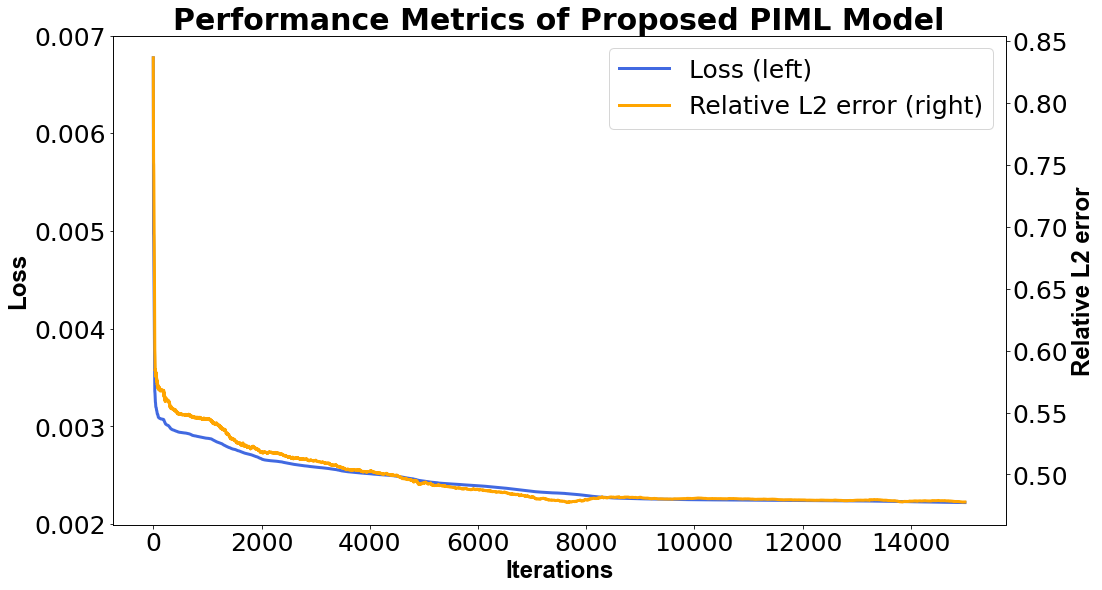

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.020380464407295934
MSE =  0.0028985198459581096
RMSE =  0.053837903432044136
L2 relative error = 0.5007855501188307
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

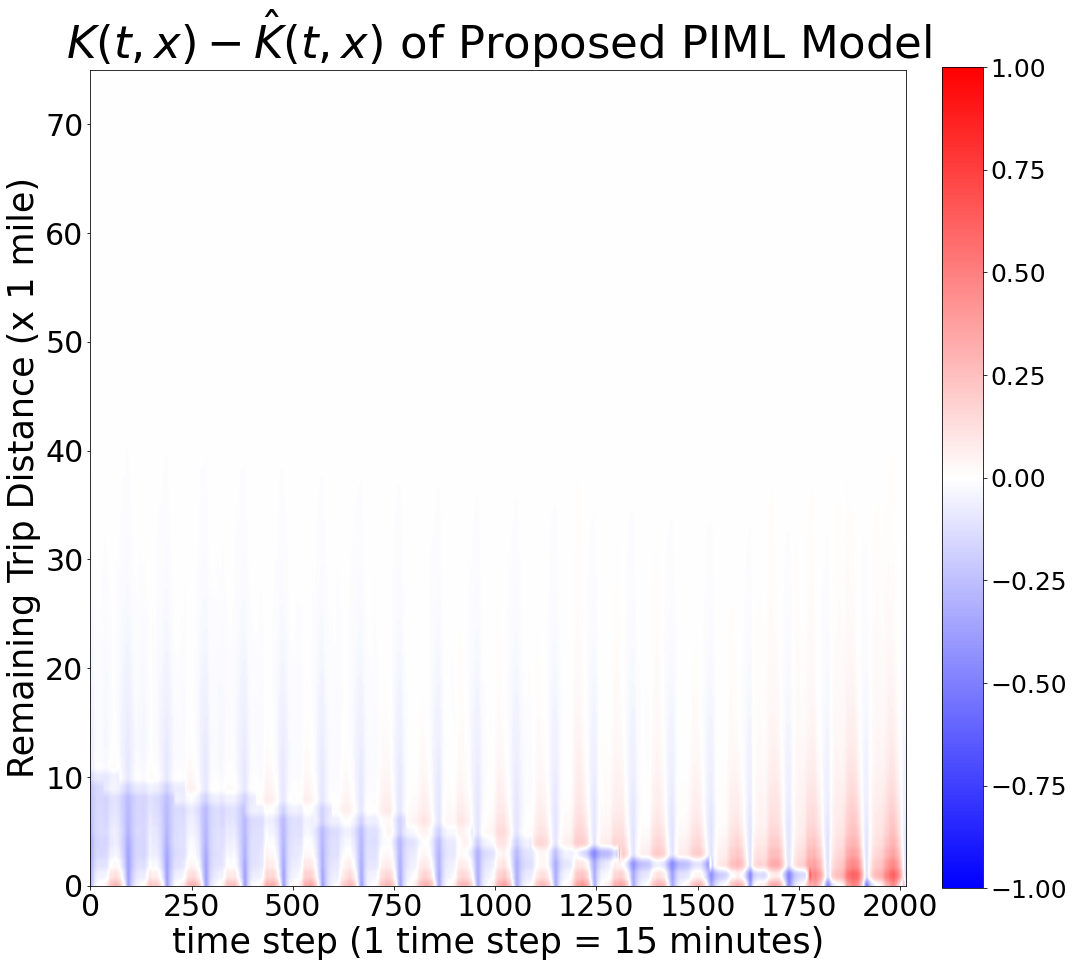

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

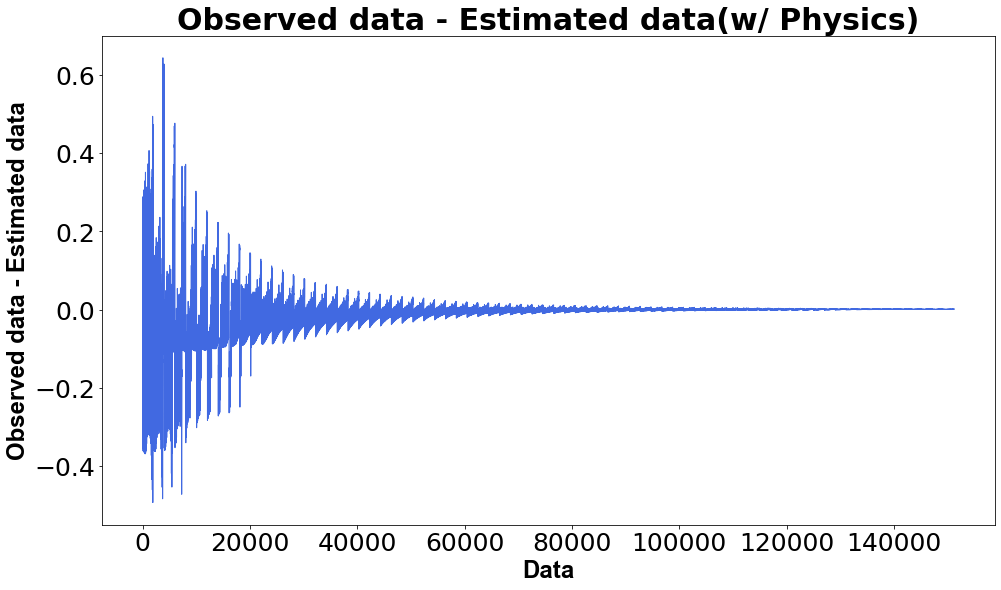

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

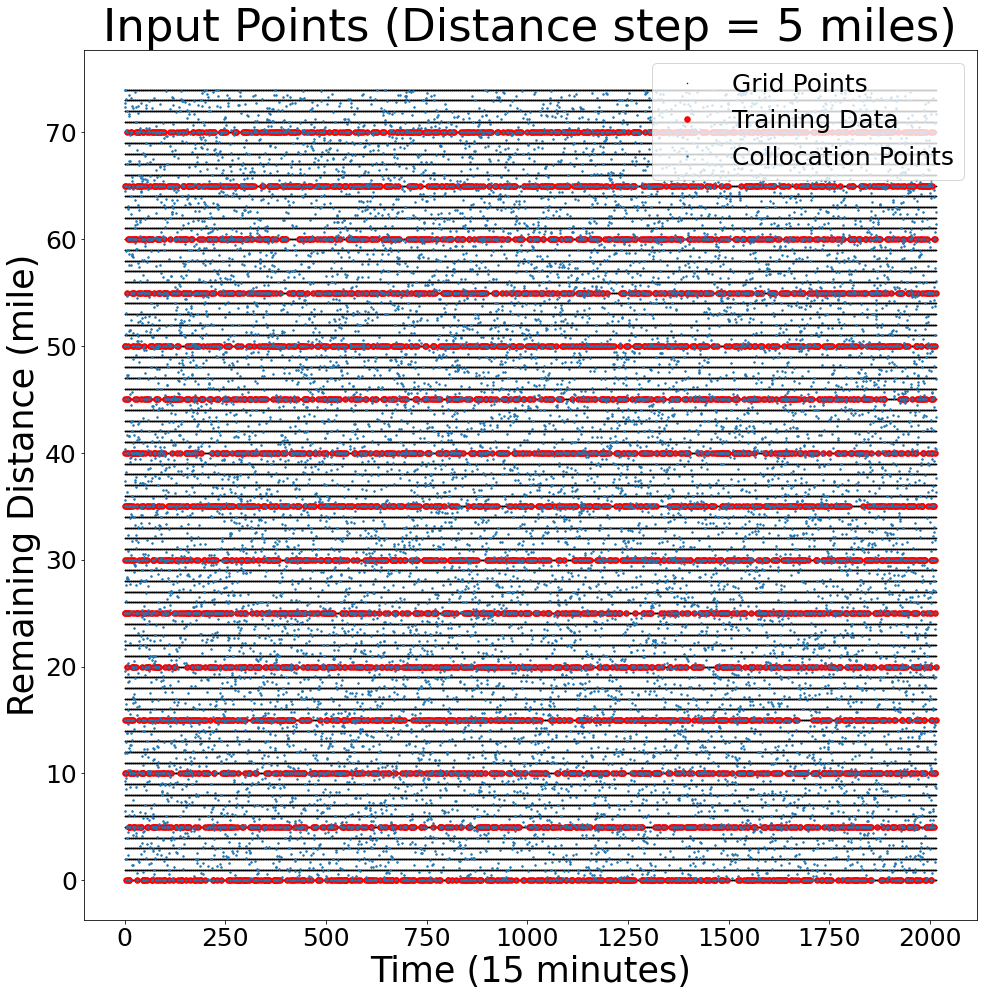

In [21]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()